In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import os
import FiShPy.FiSh as FS
from scipy.spatial import distance
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from nltk.cluster.kmeans import KMeansClusterer
%matplotlib inline

In [2]:
def simple_complexity(data):
    return np.sqrt(np.sum(np.diff(data)**2))

def complexity_correction_factor(t1, t2):
    complexities = [simple_complexity(t) for t in [t1,t2]]
    return max(complexities)/min(complexities)

def complexity_invariant_distance(a, b):
    return complexity_correction_factor(a, b) * np.linalg.norm(a - b)

# Load data and visualize pollutants 

In [3]:
os.chdir('../../Data/Preprocessed/')
data = {}
locations = ['centar', 'gazibaba', 'karpos', 'kicevo', 'kumanovo', 'lisice', 'miladinovci', 'tetovo']
for loc in locations:
    data[loc] = pd.read_csv(loc + '.csv')
    data[loc]['time'] = pd.to_datetime(data[loc]['time'], infer_datetime_format=True)

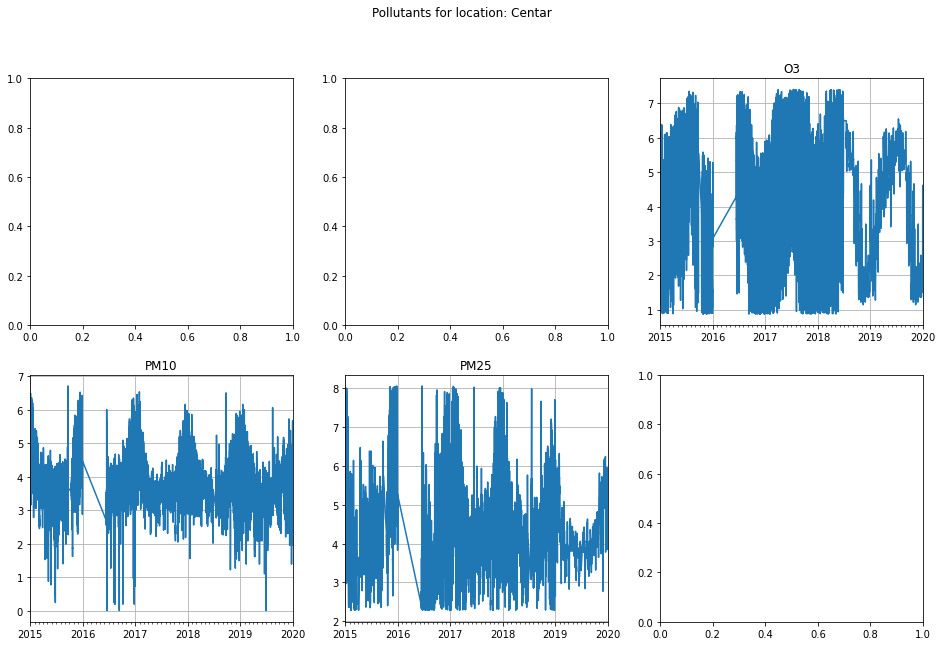

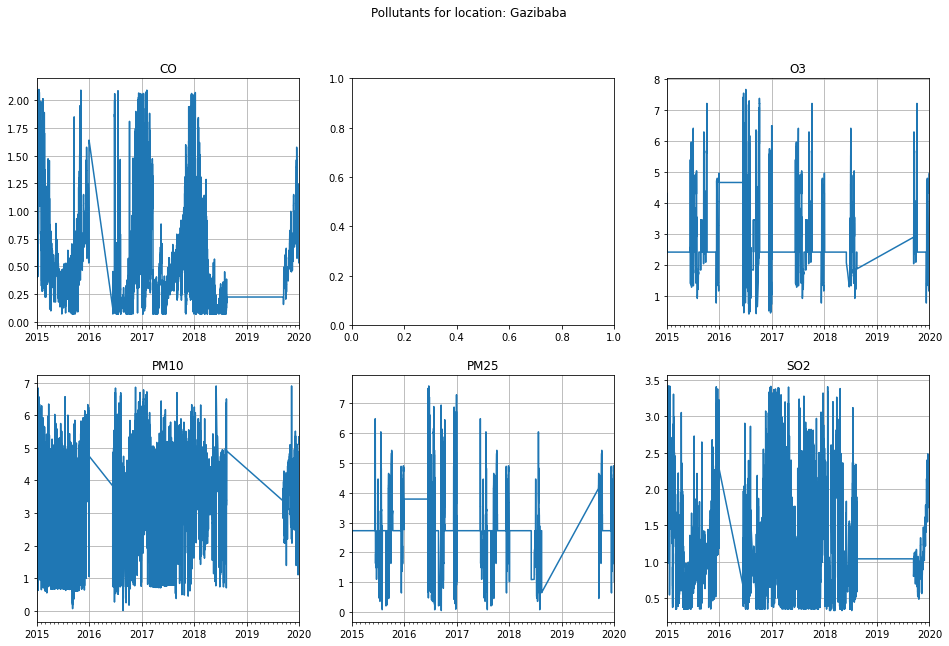

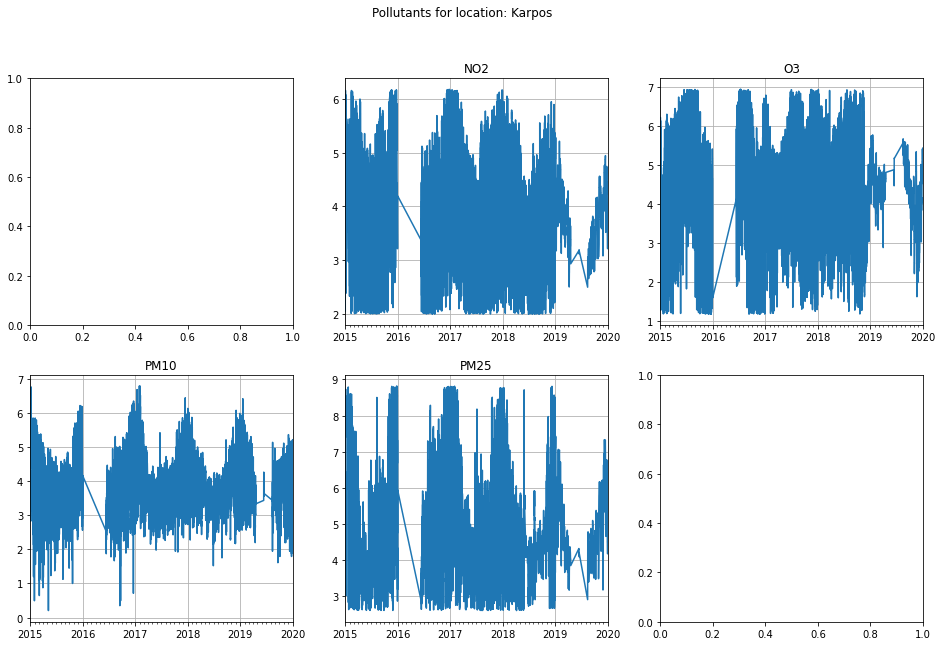

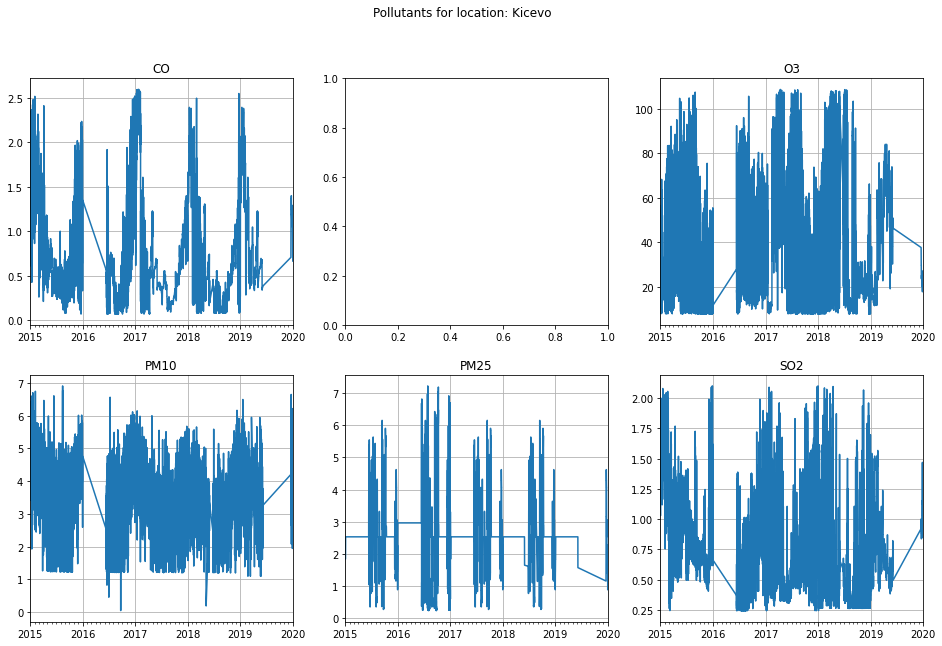

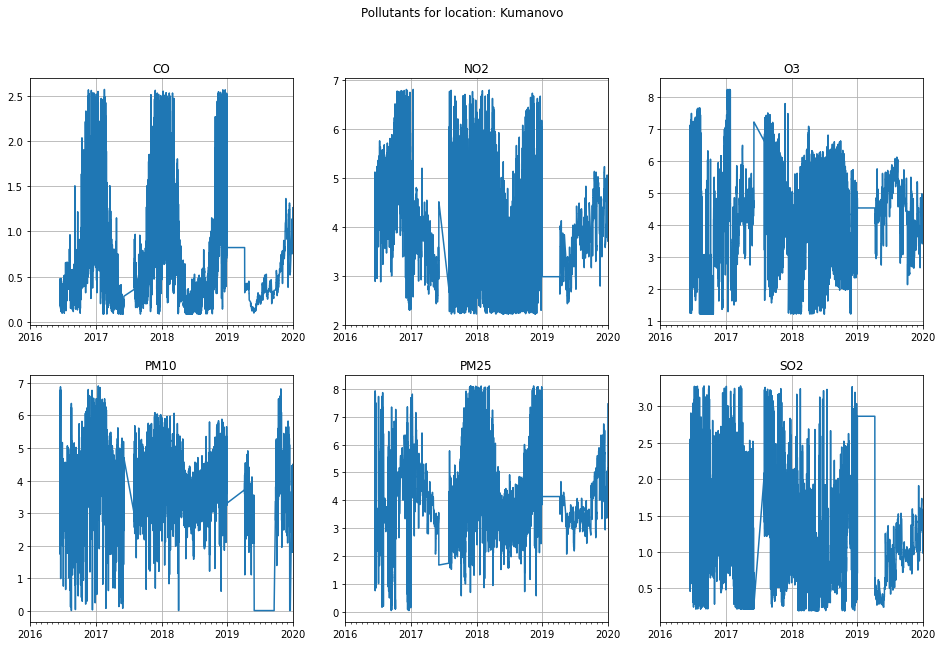

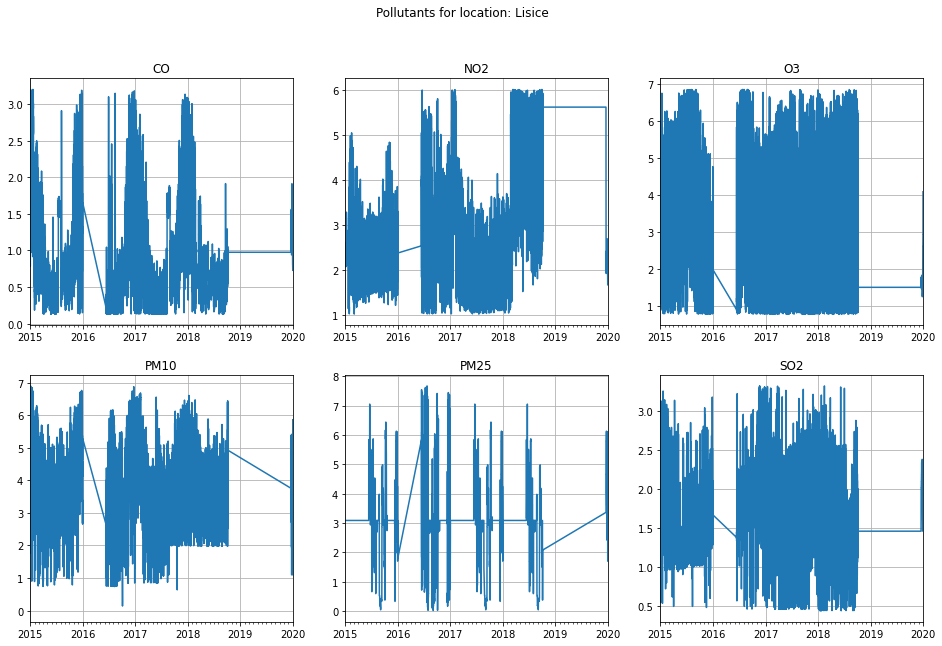

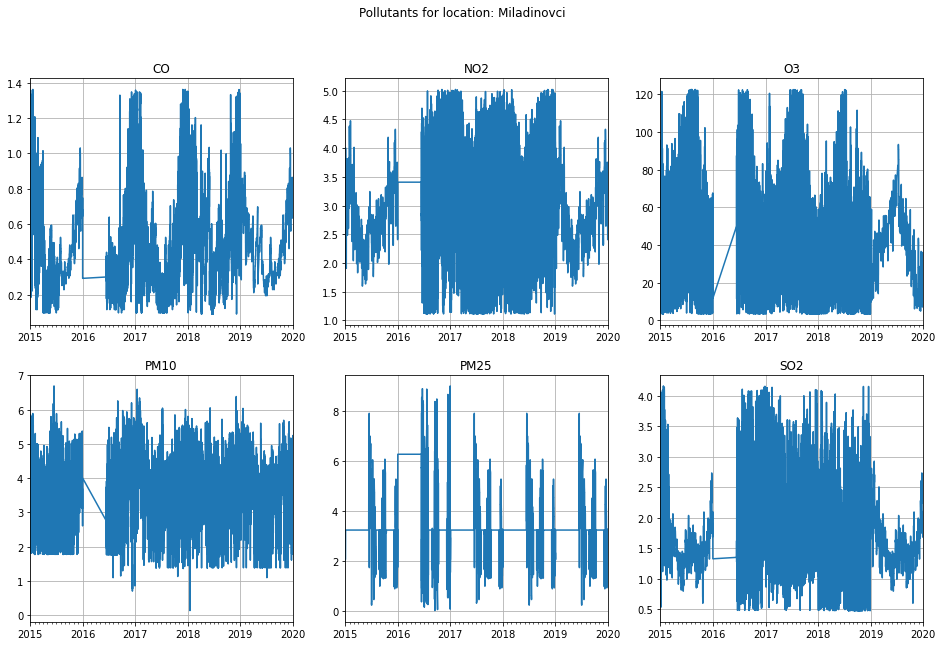

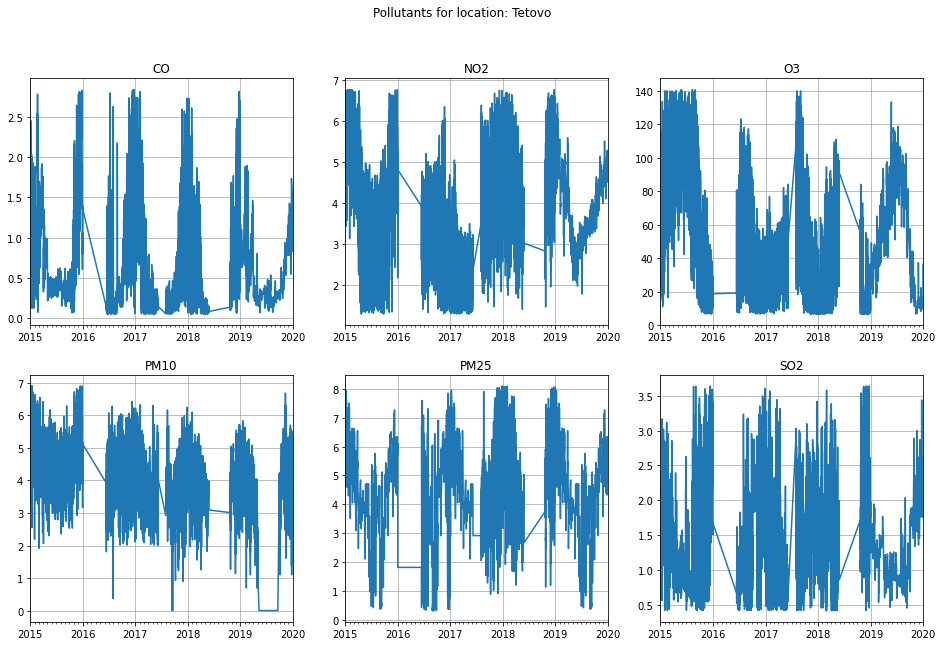

In [4]:
pollutants = ['CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2']
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
for loc in locations:
    fig = plt.figure(figsize=(16,10))
    fig.subplots(2,3)
    fig.suptitle("Pollutants for location: " + loc.capitalize())
    for i, p in enumerate(pollutants):
        if p in data[loc].columns:
            ax = plt.subplot(2,3,i+1)
            # format the ticks
            ax.xaxis.set_major_locator(years)
            ax.xaxis.set_major_formatter(years_fmt)
            ax.xaxis.set_minor_locator(months)

            # round to nearest years.
            datemin = np.datetime64(data[loc]['time'].iloc[0], 'Y')
            datemax = np.datetime64(data[loc]['time'].iloc[-1], 'Y')
            ax.set_xlim(datemin, datemax)

            # format the coords message box
            ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
            ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
            ax.grid(True)

            plt.plot(data[loc]['time'],data[loc][p])
            plt.title(p)
plt.show()

In this notebook we will present EDA on the PM10 pullutant for all locations, as well as some clustering methods. Let us first visualize a PM10 time series, along with it's rolling mean and rolling standard deviation.

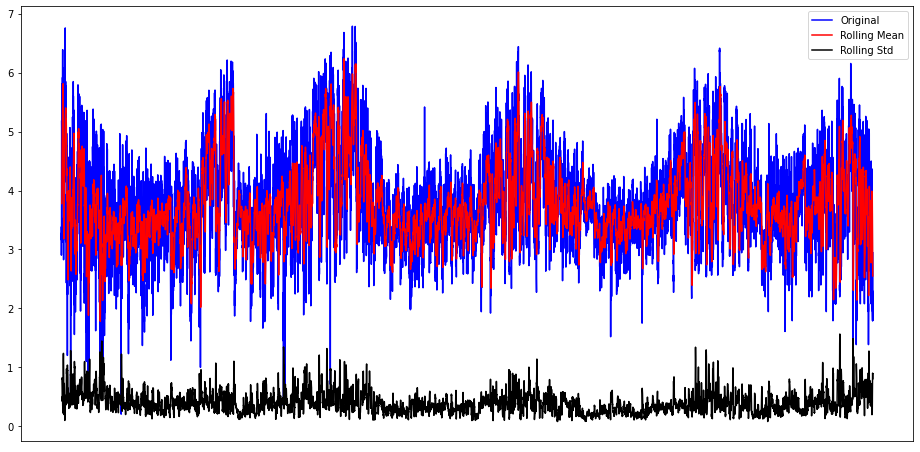

In [5]:
rolmean = data['karpos']['PM10'].rolling(window=30).mean()
rolstd = data['karpos']['PM10'].rolling(window=30).std()

fig = plt.figure(figsize=(16,8))
orig = plt.plot(data['karpos']['PM10'], color='blue', label='Original')
orig = plt.plot(rolmean, color='red', label='Rolling Mean')
orig = plt.plot(rolstd, color='black', label='Rolling Std')

plt.xticks([])
plt.legend(loc='best')
plt.show()

Because the data is too compressed, we will visualize only the last 3 months of the PM10 measurements, but will continue working with the whole time series.

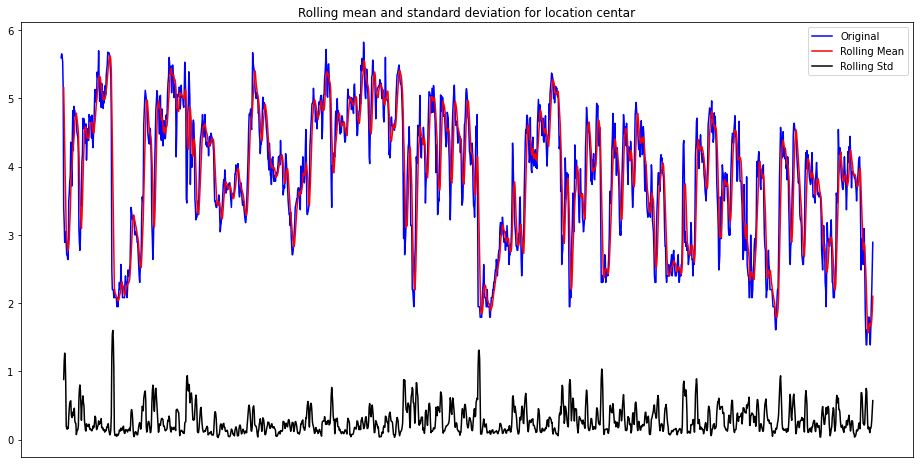

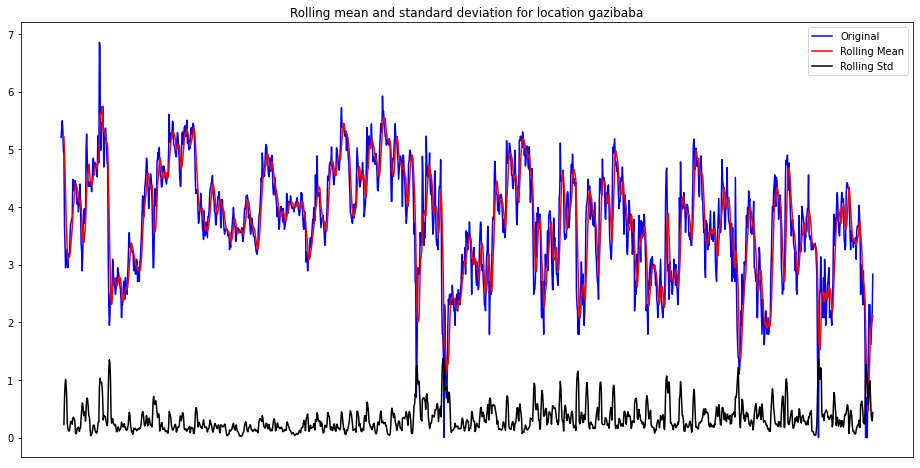

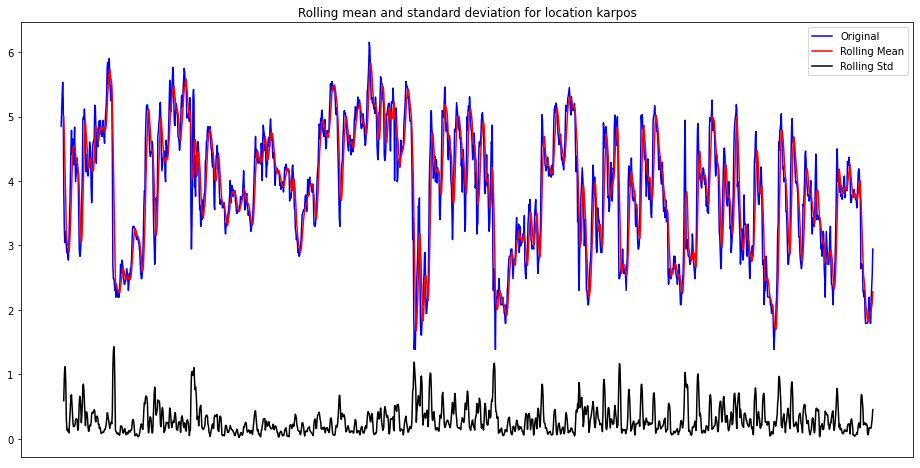

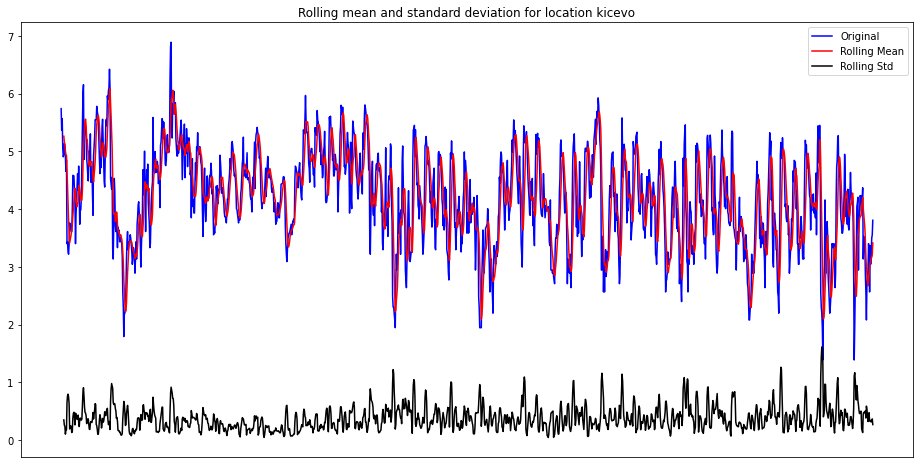

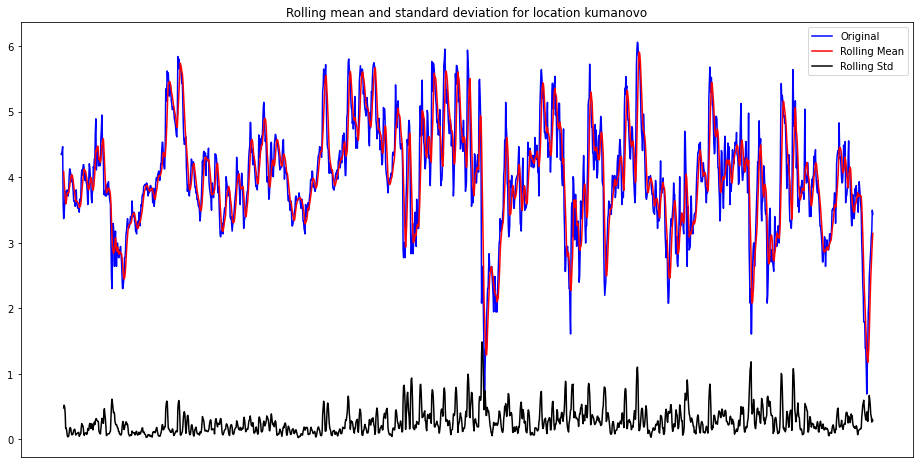

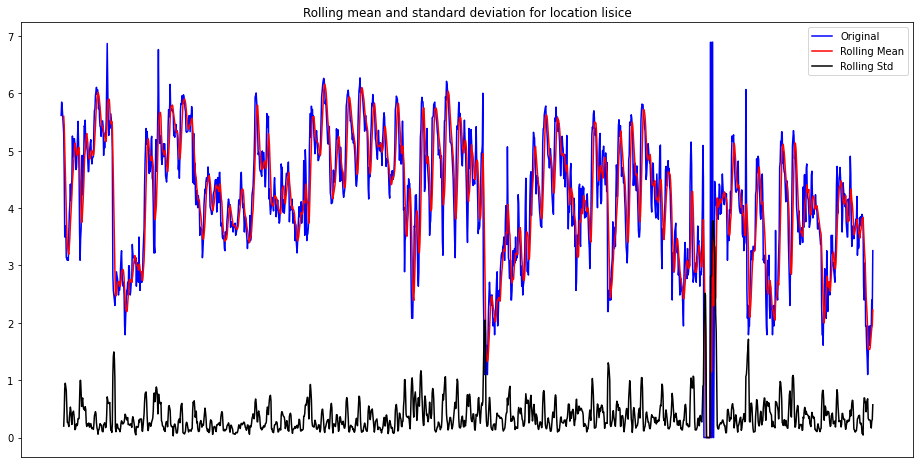

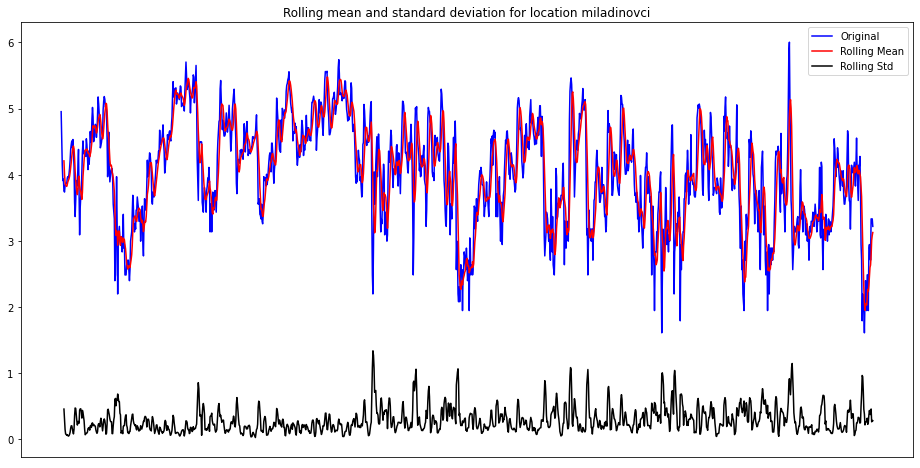

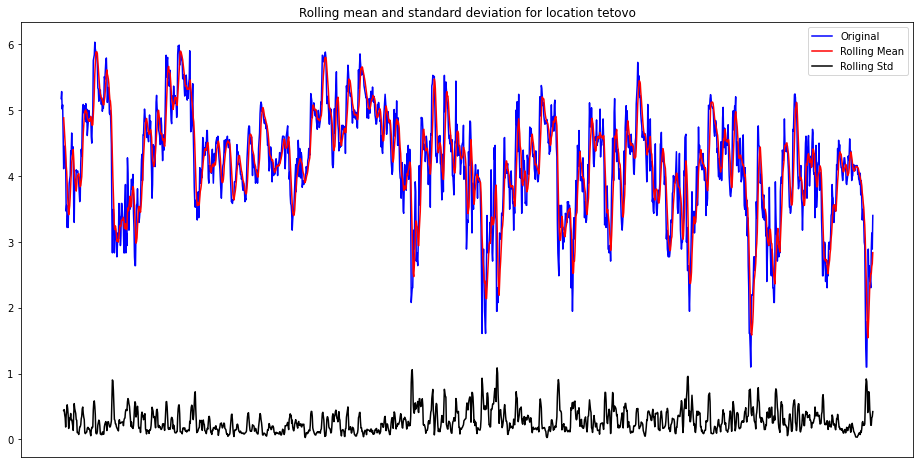

In [6]:
for loc in locations:
    df_last_year = data[loc].loc[pd.DatetimeIndex(data[loc].time).year == 2020, ['time', 'PM10']]
    rolmean = df_last_year['PM10'].rolling(window=6).mean()
    rolstd = df_last_year['PM10'].rolling(window=6).std()

    fig = plt.figure(figsize=(16,8))
    orig = plt.plot(df_last_year['PM10'], color='blue', label='Original')
    orig = plt.plot(rolmean, color='red', label='Rolling Mean')
    orig = plt.plot(rolstd, color='black', label='Rolling Std')

    plt.xticks([])
    plt.legend(loc='best')
    plt.title("Rolling mean and standard deviation for location " + loc)
plt.show()

As we can see, the data doesn't look like it has some serious seasonalities and trends, so we will preform a Dickey-Fuller test, to check its stationarity. 

In [7]:
# Stationarity test
from statsmodels.tsa.stattools import adfuller
from functools import reduce

for loc in locations:
#     if reduce(lambda a,b: not (a or b), data[loc]['PM10'].isna()):
    print("Results of Dickey-Fuller Test on PM10 pollutant at {} location\n".format(loc))
    dftest = adfuller(data[loc]['PM10'], autolag='AIC')

    dfoutput = pd.Series(dftest[:4], index=['Test Statistic\t', 'p-value\t\t', 
                                            '#Lags used\t', '#Observations used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k] = v
    for col in dfoutput.index:
        print('\t' + col + '\t' + str(dfoutput.loc[col]))
    print()

Results of Dickey-Fuller Test on PM10 pollutant at centar location

	Test Statistic		-15.628209295775399
	p-value			1.6983051630686424e-28
	#Lags used		51.0
	#Observations used	37372.0
	Critical Value (1%)	-3.430524990613739
	Critical Value (5%)	-2.861617341681528
	Critical Value (10%)	-2.5668111665194053

Results of Dickey-Fuller Test on PM10 pollutant at gazibaba location

	Test Statistic		-11.852080357739334
	p-value			7.16903697599675e-22
	#Lags used		50.0
	#Observations used	28735.0
	Critical Value (1%)	-3.4305775929793576
	Critical Value (5%)	-2.861640589782319
	Critical Value (10%)	-2.566823540899786

Results of Dickey-Fuller Test on PM10 pollutant at karpos location

	Test Statistic		-15.449593127898162
	p-value			2.7955281611738775e-28
	#Lags used		50.0
	#Observations used	35793.0
	Critical Value (1%)	-3.430532710838331
	Critical Value (5%)	-2.8616207537318066
	Critical Value (10%)	-2.566812982663622

Results of Dickey-Fuller Test on PM10 pollutant at kicevo location

	Test St

The Dickey-Fuller tests show that all of our PM10 time series (on all locations) are stationary. We will try to further improve our time series by preforming two different methods for seasonality and trend removal: Moving average method, and Differencing method.

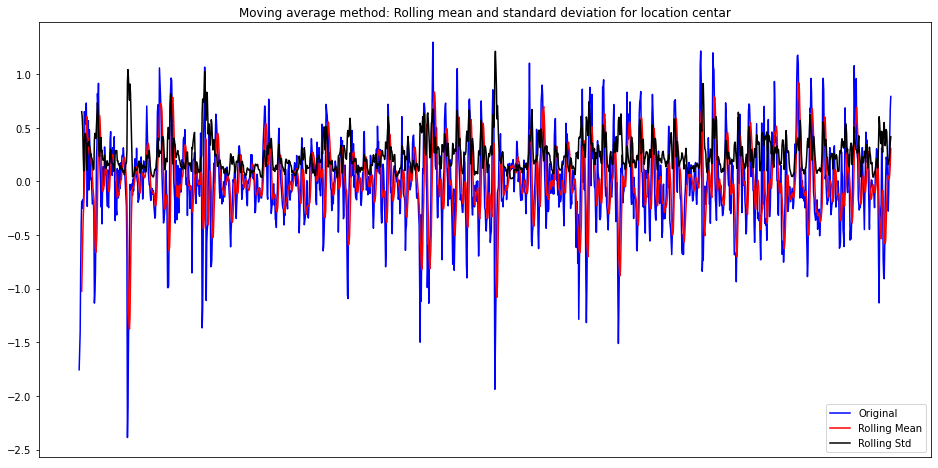

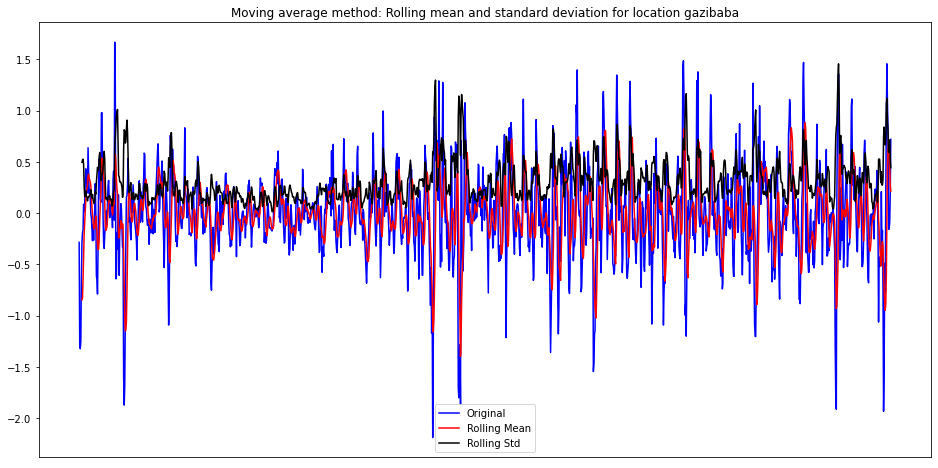

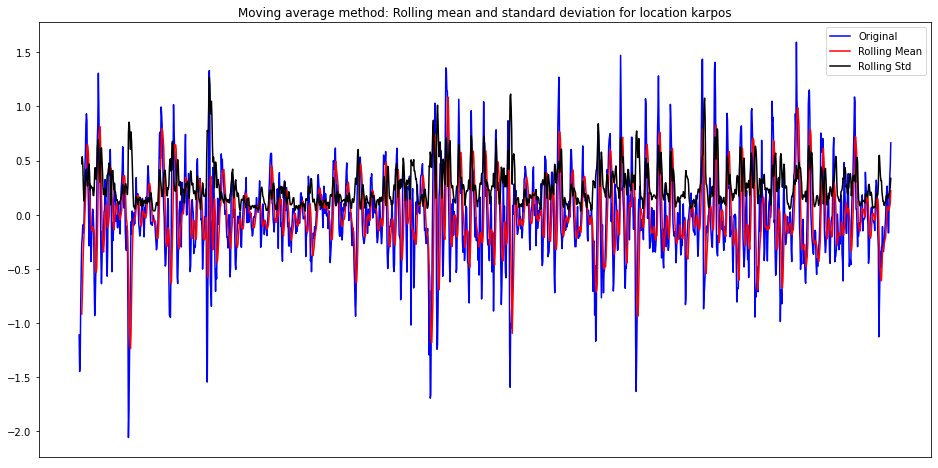

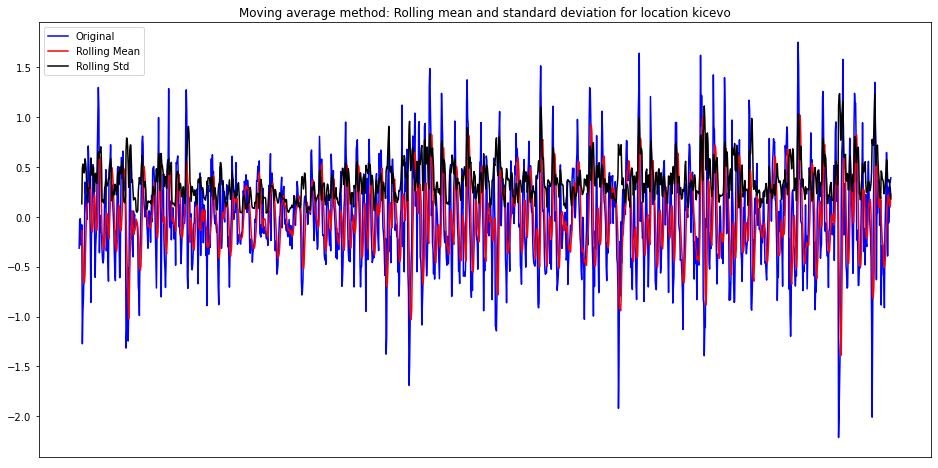

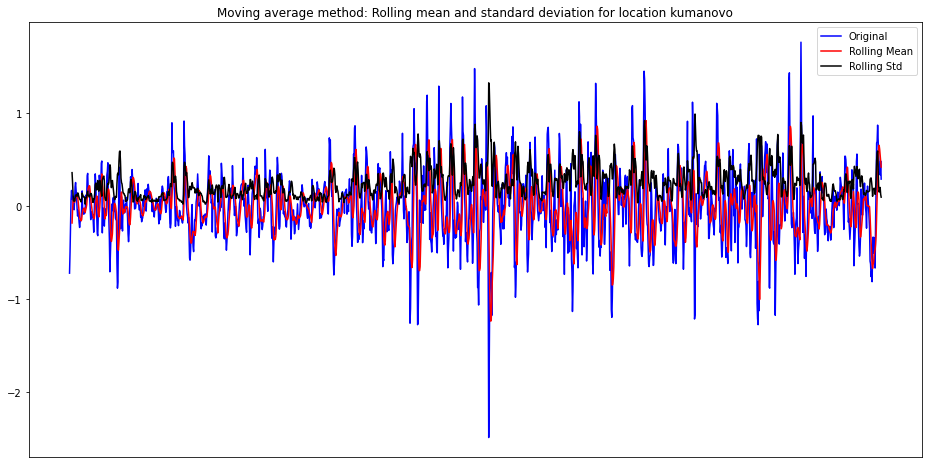

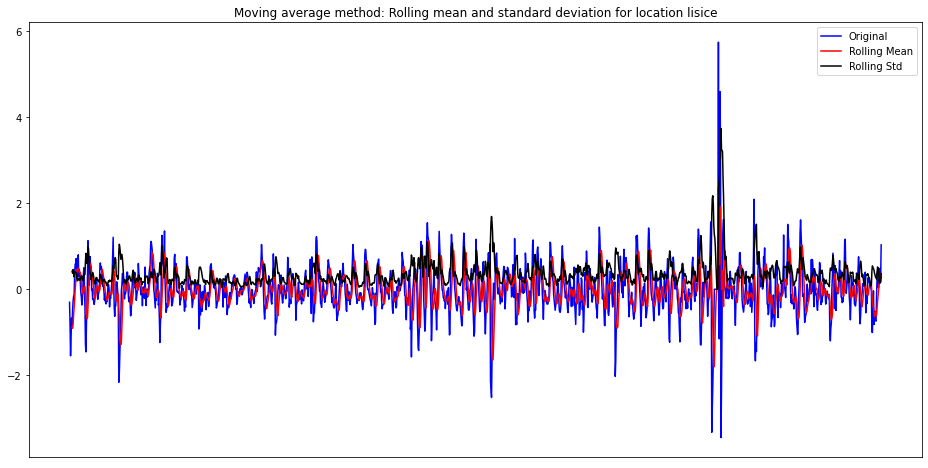

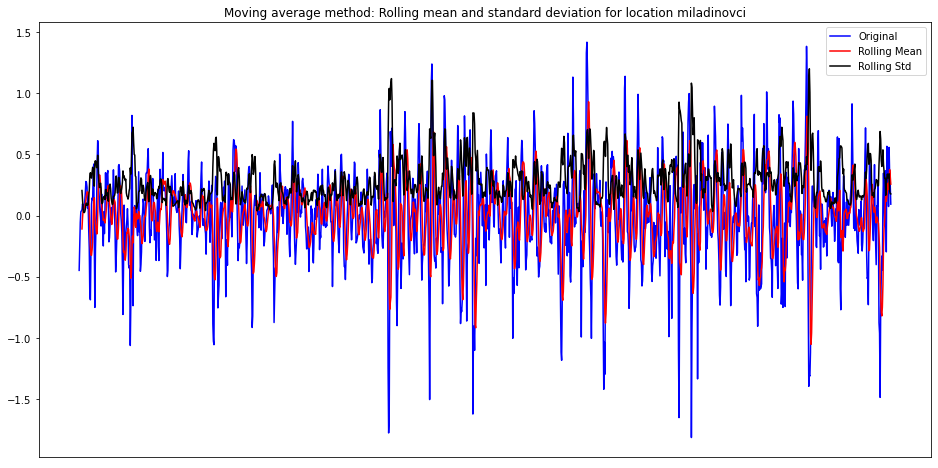

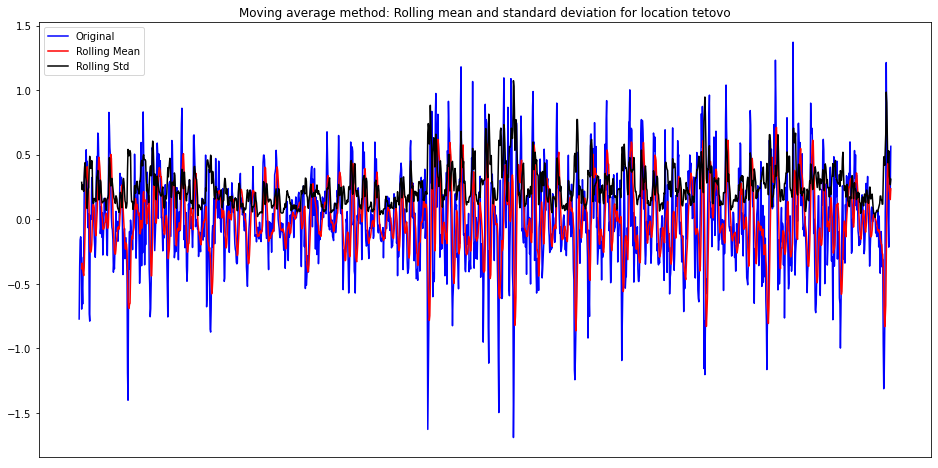

In [8]:
# This is the Moving average method. Let's subtract the rolling mean of the time series
# and see the results for the rolling mean and std on that modified series.
for loc in locations:
    df_last_year = data[loc].loc[pd.DatetimeIndex(data[loc].time).year == 2020, ['time', 'PM10']]
    rolmean = df_last_year['PM10'].rolling(window=6).mean()
    rolstd = df_last_year['PM10'].rolling(window=6).std()

    moving_avg_diff = df_last_year['PM10'] - rolmean
    rolmean = moving_avg_diff.rolling(window=6).mean()
    rolstd = moving_avg_diff.rolling(window=6).std()
    
    fig = plt.figure(figsize=(16,8))
    orig = plt.plot(moving_avg_diff, color='blue', label='Original')
    orig = plt.plot(rolmean, color='red', label='Rolling Mean')
    orig = plt.plot(rolstd, color='black', label='Rolling Std')

    plt.xticks([])
    plt.legend(loc='best')
    plt.title("Moving average method: Rolling mean and standard deviation for location " + loc)
plt.show()

In [9]:
# Stationarity test on data with subtracted rolling mean
for loc in locations:
    print("Results of Dickey-Fuller Test on PM10 pollutant at {} location\n".format(loc))
    rolmean = data[loc]['PM10'].rolling(window=6).mean()
    moving_avg_diff = data[loc]['PM10'] - rolmean
    moving_avg_diff.dropna(inplace=True)
    dftest = adfuller(moving_avg_diff, autolag='AIC')

    dfoutput = pd.Series(dftest[:4], index=['Test Statistic\t', 'p-value\t\t', 
                                            '#Lags used\t', '#Observations used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k] = v
    for col in dfoutput.index:
        print('\t' + col + '\t' + str(dfoutput.loc[col]))
    print()

Results of Dickey-Fuller Test on PM10 pollutant at centar location

	Test Statistic		-33.83134428426237
	p-value			0.0
	#Lags used		53.0
	#Observations used	37365.0
	Critical Value (1%)	-3.430525023398925
	Critical Value (5%)	-2.8616173561713714
	Critical Value (10%)	-2.566811174231963

Results of Dickey-Fuller Test on PM10 pollutant at gazibaba location

	Test Statistic		-32.01322215570541
	p-value			0.0
	#Lags used		48.0
	#Observations used	28732.0
	Critical Value (1%)	-3.4305776167451922
	Critical Value (5%)	-2.8616406002857557
	Critical Value (10%)	-2.5668235464905176

Results of Dickey-Fuller Test on PM10 pollutant at karpos location

	Test Statistic		-31.98232741665763
	p-value			0.0
	#Lags used		53.0
	#Observations used	35785.0
	Critical Value (1%)	-3.4305327516876134
	Critical Value (5%)	-2.8616207717856366
	Critical Value (10%)	-2.5668129922732033

Results of Dickey-Fuller Test on PM10 pollutant at kicevo location

	Test Statistic		-34.74344034822704
	p-value			0.0
	#Lags used

As we can see, we get even more stationary time series this way. One last method is to apply the differencing method, taking the difference between time series and shifted time series.

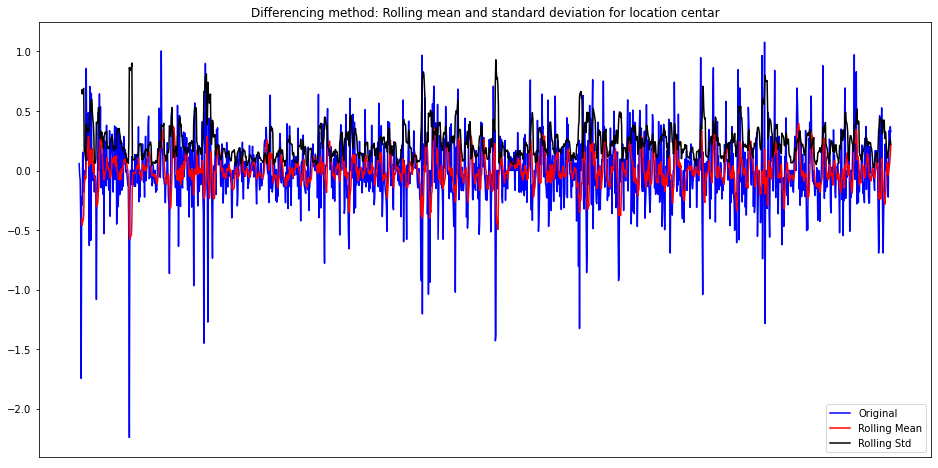

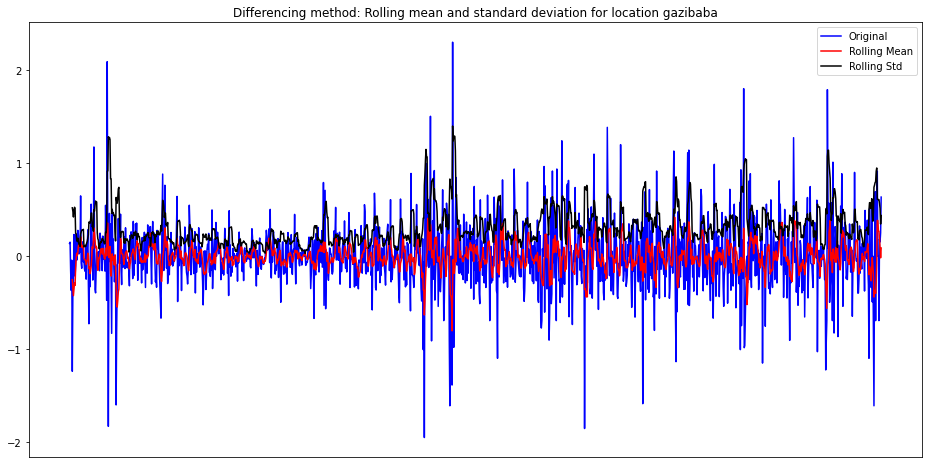

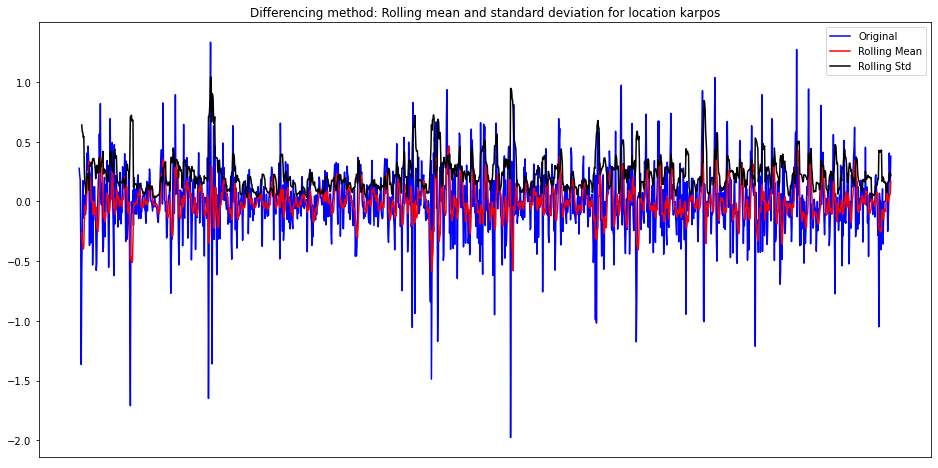

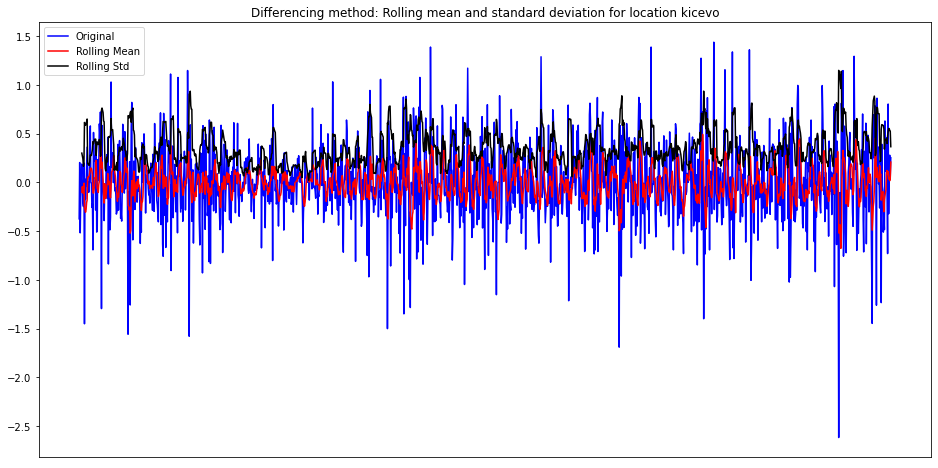

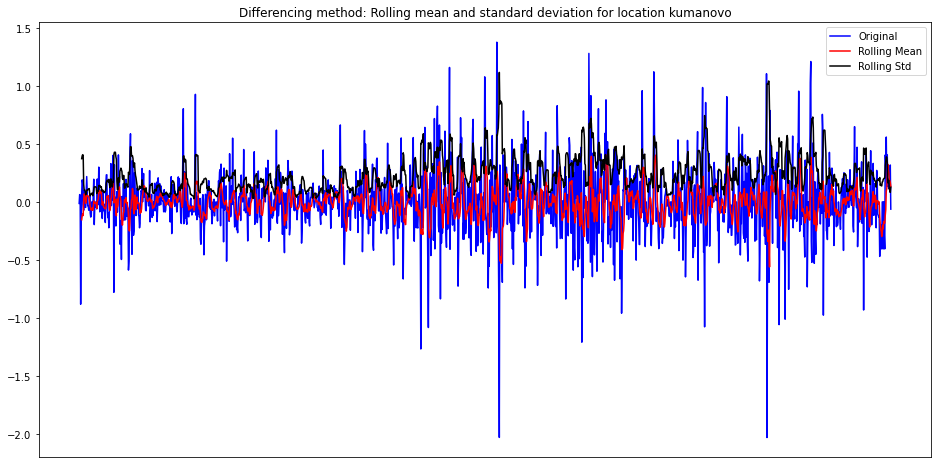

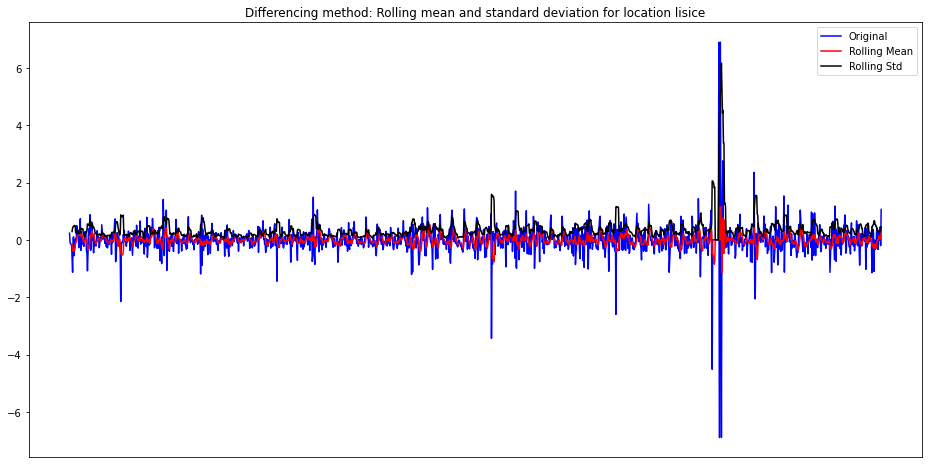

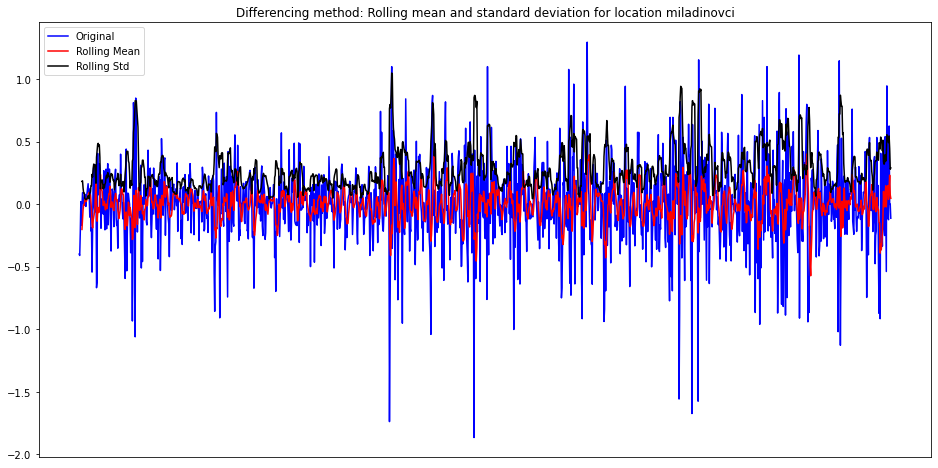

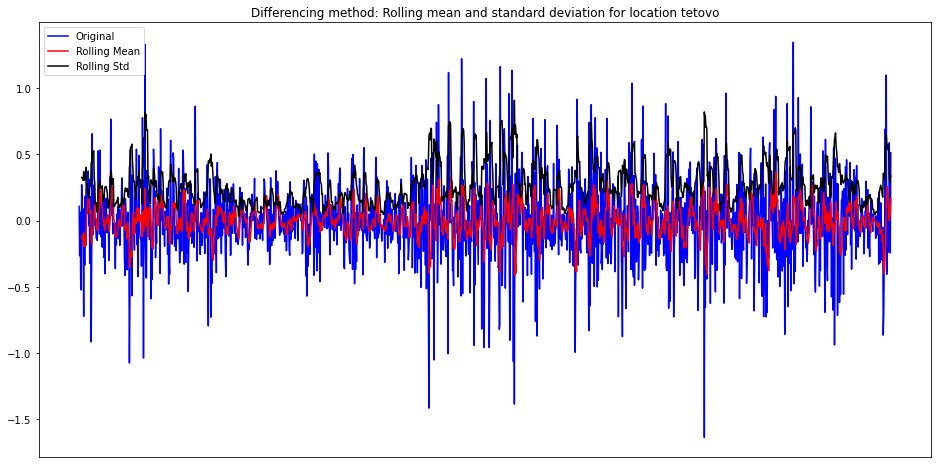

In [10]:
# Differencing method
for loc in locations:
    df_last_year = data[loc].loc[pd.DatetimeIndex(data[loc].time).year == 2020, ['time', 'PM10']]

    shifted_diff = df_last_year['PM10'] - df_last_year['PM10'].shift()
    rolmean = shifted_diff.rolling(window=6).mean()
    rolstd = shifted_diff.rolling(window=6).std()
    
    fig = plt.figure(figsize=(16,8))
    orig = plt.plot(shifted_diff, color='blue', label='Original')
    orig = plt.plot(rolmean, color='red', label='Rolling Mean')
    orig = plt.plot(rolstd, color='black', label='Rolling Std')

    plt.xticks([])
    plt.legend(loc='best')
    plt.title("Differencing method: Rolling mean and standard deviation for location " + loc)
plt.show()

In [11]:
# Stationarity test on data derived from differencing method
data_diff = {}
for loc in locations:
    print("Results of Dickey-Fuller Test on PM10 pollutant at {} location\n".format(loc))
    shifted_diff = data[loc]['PM10'] - data[loc]['PM10'].shift()
    shifted_diff.dropna(inplace=True)
    data_diff[loc] = shifted_diff
    dftest = adfuller(shifted_diff, autolag='AIC')

    dfoutput = pd.Series(dftest[:4], index=['Test Statistic\t', 'p-value\t\t', 
                                            '#Lags used\t', '#Observations used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k] = v
    for col in dfoutput.index:
        print('\t' + col + '\t' + str(dfoutput.loc[col]))
    print()

Results of Dickey-Fuller Test on PM10 pollutant at centar location

	Test Statistic		-33.71726750118691
	p-value			0.0
	#Lags used		53.0
	#Observations used	37369.0
	Critical Value (1%)	-3.430525004663029
	Critical Value (5%)	-2.861617347890796
	Critical Value (10%)	-2.5668111698244336

Results of Dickey-Fuller Test on PM10 pollutant at gazibaba location

	Test Statistic		-32.44912042680868
	p-value			0.0
	#Lags used		50.0
	#Observations used	28734.0
	Critical Value (1%)	-3.430577600900751
	Critical Value (5%)	-2.8616405932832207
	Critical Value (10%)	-2.5668235427632333

Results of Dickey-Fuller Test on PM10 pollutant at karpos location

	Test Statistic		-33.98475572878837
	p-value			0.0
	#Lags used		48.0
	#Observations used	35794.0
	Critical Value (1%)	-3.4305327057334543
	Critical Value (5%)	-2.861620751475645
	Critical Value (10%)	-2.5668129814627267

Results of Dickey-Fuller Test on PM10 pollutant at kicevo location

	Test Statistic		-33.47208362036175
	p-value			0.0
	#Lags used		

Both methods for removing seasonality and trend do well, so we pick the data gathered from the differencing method for further analysis of the time series. Lets check the autocorrelation (ACF) and partial autocorrelation (PACF) of our time series

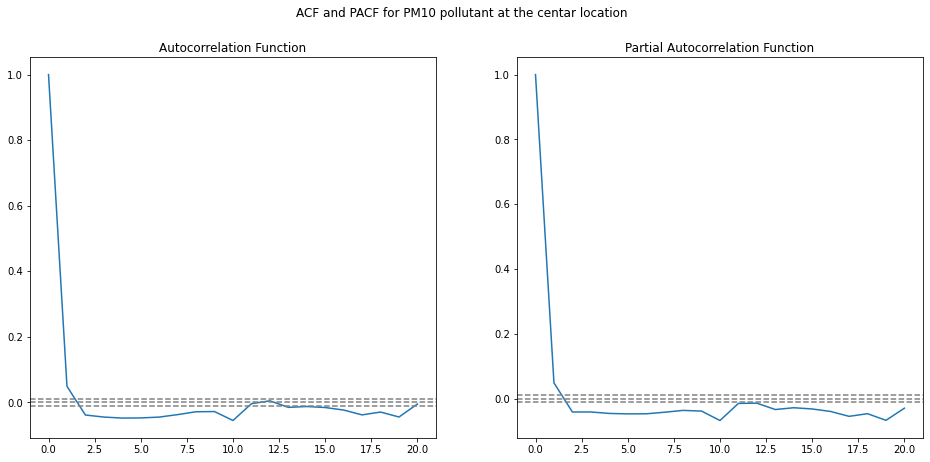

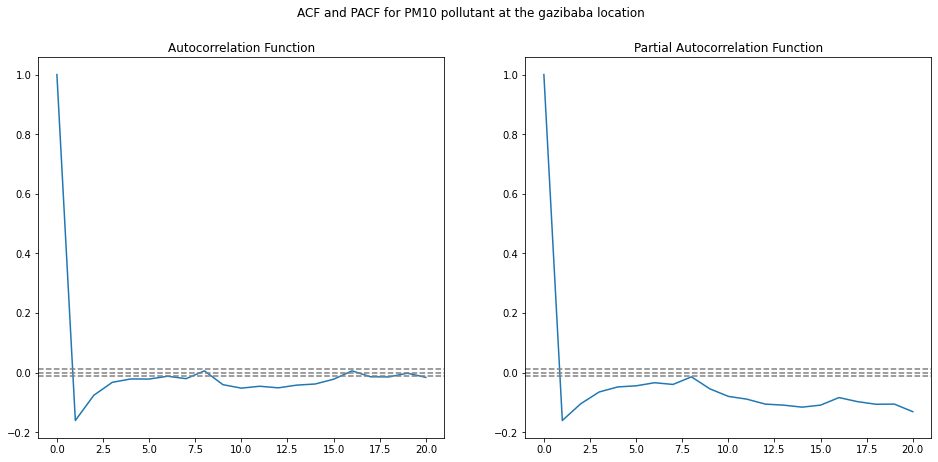

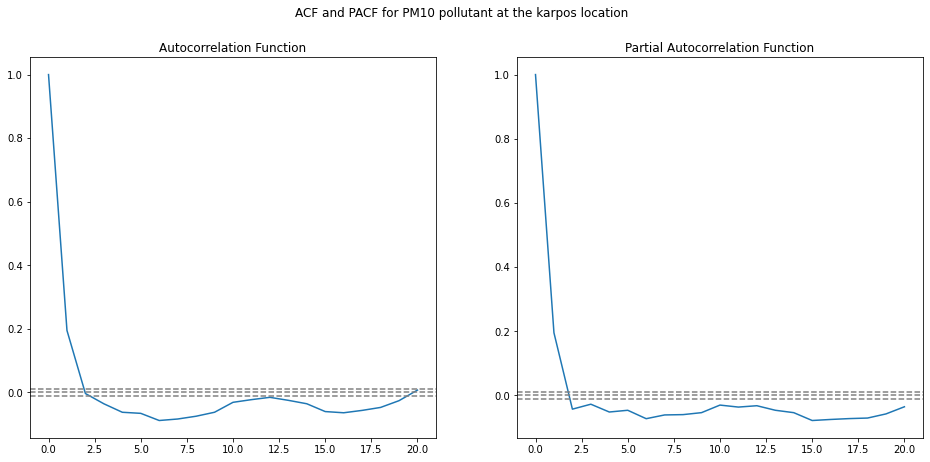

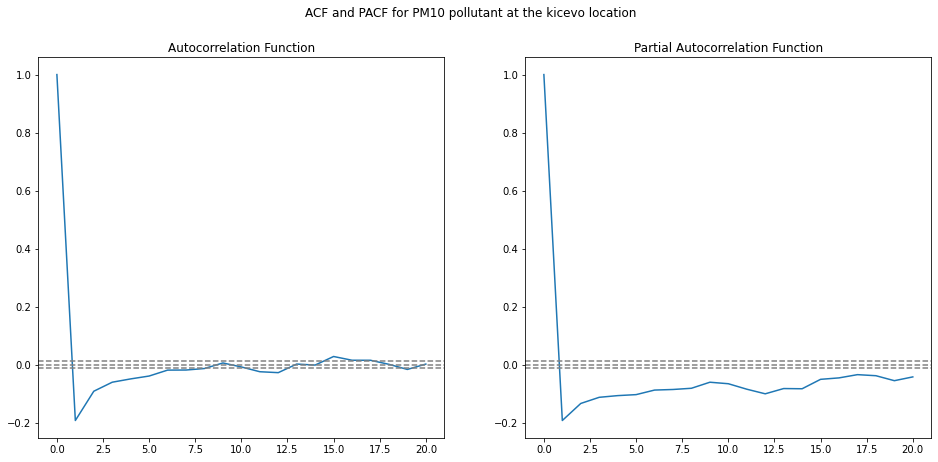

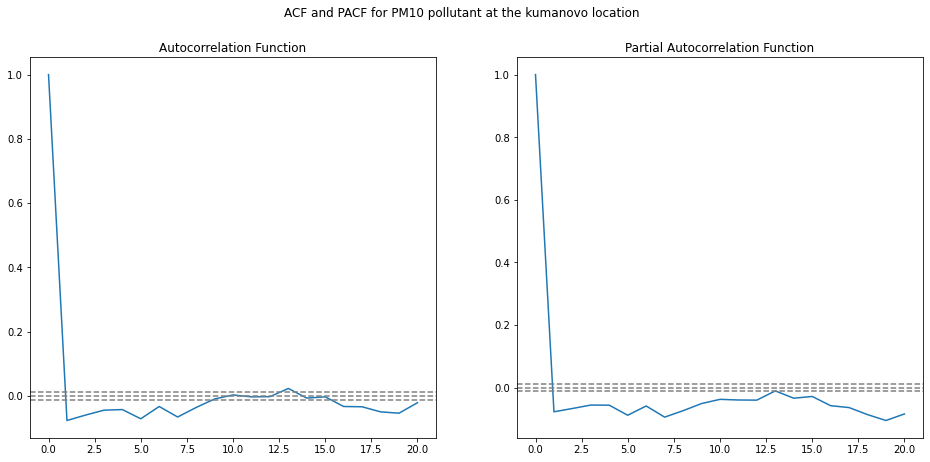

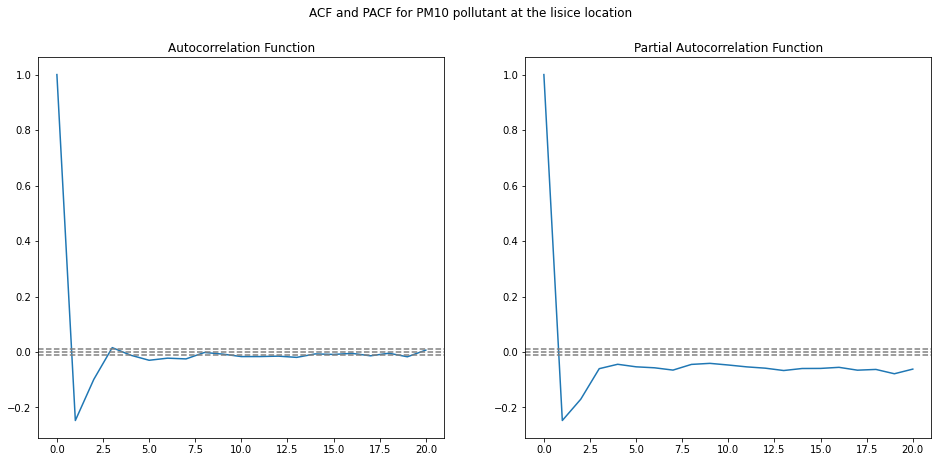

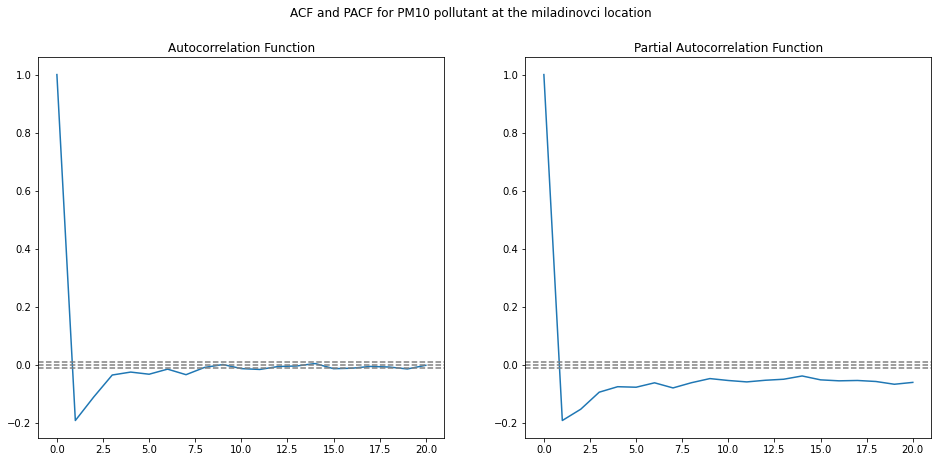

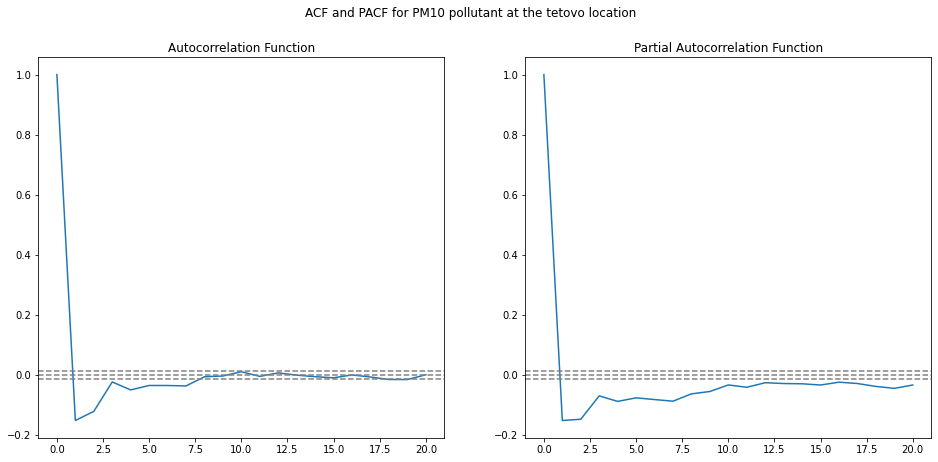

In [12]:
# ACF and PACF 
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for loc in locations:
    lag_acf = acf(data_diff[loc], nlags=20)
    lag_pacf = pacf(data_diff[loc], nlags=20, method='ols')
    # ACF
    fig = plt.figure(figsize=(16,7))
    fig.suptitle("ACF and PACF for PM10 pollutant at the {} location".format(loc))

    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data_diff[loc])),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data_diff[loc])),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    # PACF
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data_diff[loc])),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data_diff[loc])),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
plt.show()

These results from this analysis can help us determine the parameters for a future ARIMA model. The dotted horisontal lines represent confidence intervals.

# Clustering

All clustering is done on the PM10 variable. First we draw all time series on one plot to see their similarity.

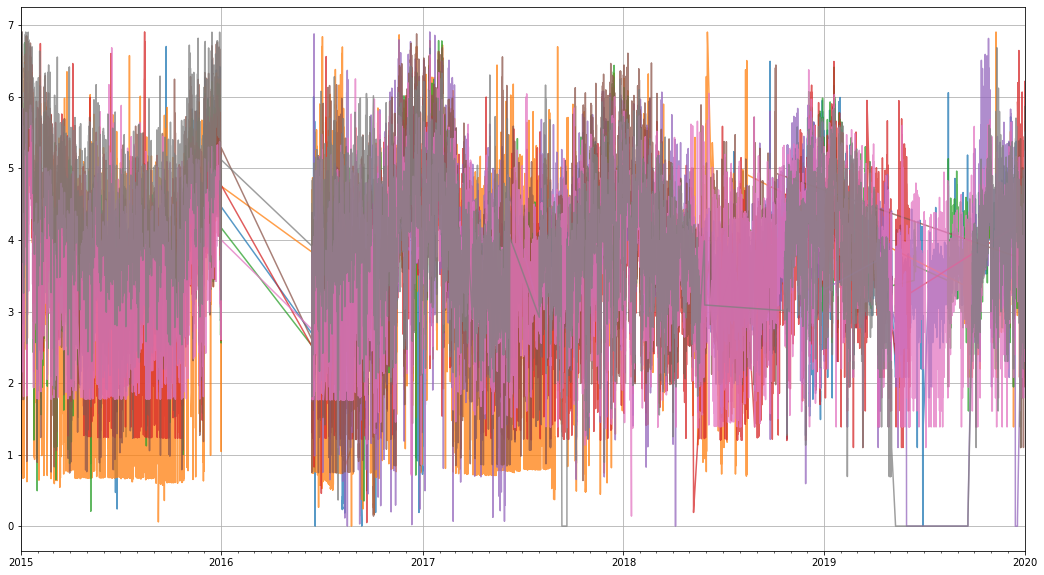

In [14]:
fig, ax = plt.subplots(figsize=(18, 10))
for loc in locations:
    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)

    # round to nearest years.
    datemin = np.datetime64(data[loc]['time'].iloc[0], 'Y')
    datemax = np.datetime64(data[loc]['time'].iloc[-1], 'Y')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    ax.grid(True)

    plt.plot(data[loc]['time'], data[loc]['PM10'], alpha=.75)
plt.show()

Again, the data is too big and we cannot get any valuable info just by looking at this plot. We will work with last 3 months of the PM10 measurements

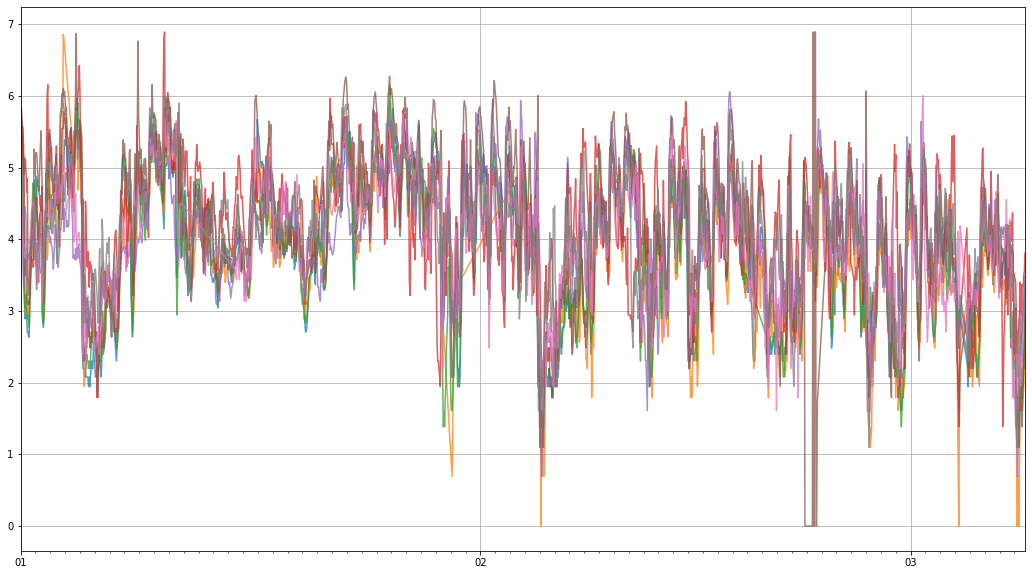

In [15]:
fig, ax = plt.subplots(figsize=(18, 10))
months_fmt = mdates.DateFormatter('%m')
days = mdates.DayLocator()
for loc in locations:
    df_last_year = data[loc].loc[pd.DatetimeIndex(data[loc].time).year == 2020, ['time', 'PM10']]
    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)
    ax.xaxis.set_minor_locator(days)

    # round to nearest months.
    datemin = np.datetime64(df_last_year['time'].iloc[0], 'm')
    datemax = np.datetime64(df_last_year['time'].iloc[-1], 'm')
    ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    ax.grid(True)

    plt.plot(df_last_year['time'], df_last_year['PM10'], alpha=.75)
plt.show()

## On PM10 pollutant at all the locations

We use the Shannon Entropy Power and the  Fisher Information Measure of our time series to discribe it in the so called Fisher-Shannon plane. For each location we derive these two characteristics from the PM10 time series and plot the results.

In [16]:
fsp_pm10 = pd.DataFrame(columns=['loc','sep','fim'])
sep, fim = [], []
for loc in locations:
    h = FS.dpik(data[loc]['PM10'])
    SEP, FIM, FSC = FS.SEP_FIM(data[loc]['PM10'], h, log_trsf=False)
    sep.append(SEP)
    fim.append(FIM)
fsp_pm10['loc'] = locations
fsp_pm10['sep'] = sep
fsp_pm10['fim'] = fim
fsp_pm10.set_index('loc', inplace=True)
display(fsp_pm10)

sep        fim
loc                             
centar       0.513395   2.939560
gazibaba     1.117808   3.711616
karpos       0.586873   2.084138
kicevo       0.754172   1.922404
kumanovo     0.609581  55.912039
lisice       0.880042   1.667952
miladinovci  0.563775   2.330096
tetovo       0.641616  72.913561

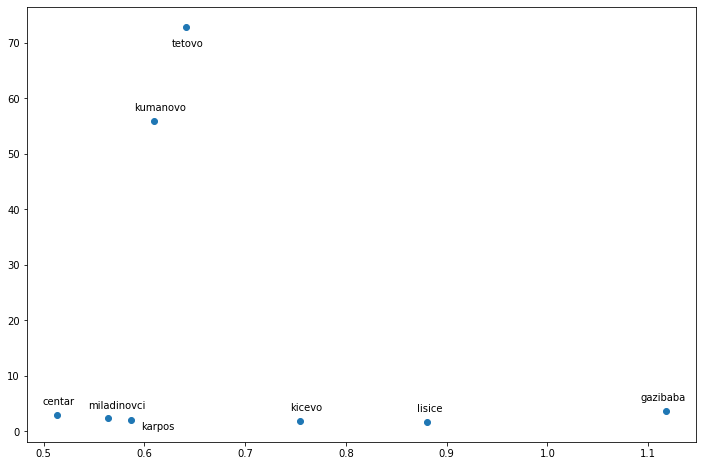

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(fsp_pm10['sep'], fsp_pm10['fim'])
xytext = [(-15, 10), (-25, 10), (10, -10), (-10, 10), (-20, 10), (-10, 10), (-20, 10), (-15, -20)]
for i, loc in enumerate(fsp_pm10.index.values):
    ax.annotate(loc, (fsp_pm10['sep'][i], fsp_pm10['fim'][i]),
                xytext=xytext[i], textcoords='offset points')
plt.show()

As we can see, the time series for some of the locations appear closer together in this plane, which could mean that there is some latent factor that brings the data from the measuring stations closer to each other, or further apart. Let's use the k-means clustering method to see which locations are most similar to one another and are assigned to the same cluster. We will also use the Complexity-Invariant distance measure, instead of the typical Euclidian distance measure, since this is the best metric for time series clustering, as described in [this paper](https://arxiv.org/pdf/1909.11484.pdf).

For n_clusters = 2 The average silhouette_score is : 0.9972032683954961
For n_clusters = 3 The average silhouette_score is : 0.7577037354231524
For n_clusters = 4 The average silhouette_score is : 0.5119313080886092
For n_clusters = 5 The average silhouette_score is : 0.34496194140734304


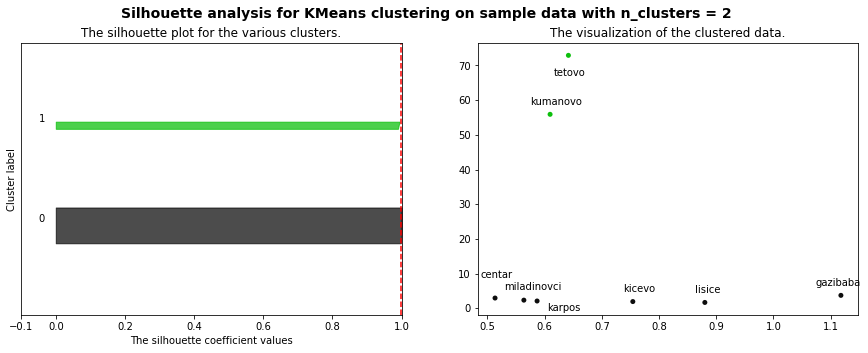

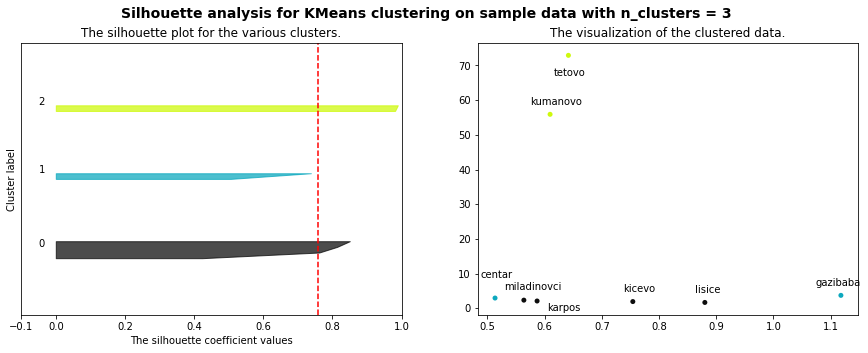

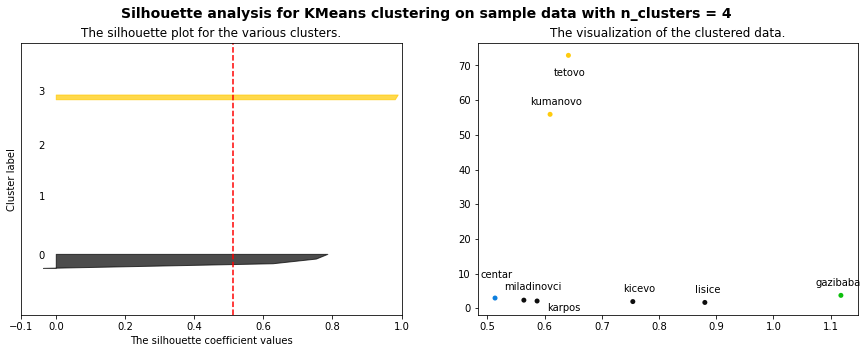

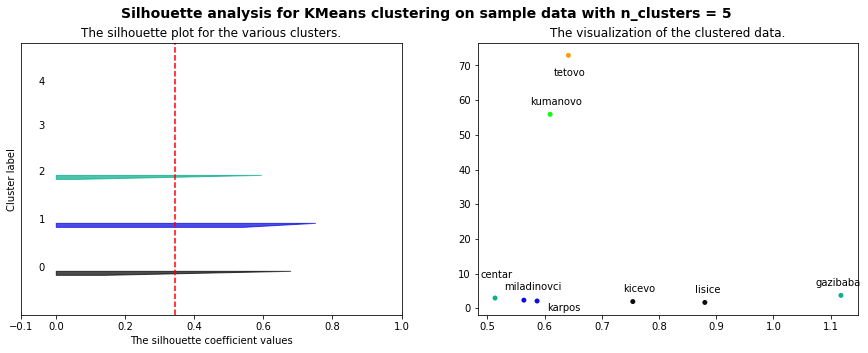

In [36]:
range_n_clusters = [2, 3, 4, 5]
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(fsp_pm10) + (n_clusters + 1) * 10])

    clusterer = KMeansClusterer(n_clusters, complexity_invariant_distance, repeats=5)
    vectors = [np.array(f) for f in fsp_pm10.to_numpy()]
    cluster_labels = np.array(clusterer.cluster(vectors, True))

    silhouette_avg = silhouette_score(fsp_pm10, cluster_labels, metric=complexity_invariant_distance)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(fsp_pm10, cluster_labels,
                                                  metric=complexity_invariant_distance)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    clrs = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(fsp_pm10['sep'], fsp_pm10['fim'], marker='.', s=100, lw=0, alpha=0.95, c=clrs, edgecolor='k')
    xytext = [(-15, 20), (-25, 10), (10, -10), (-10, 10), (-20, 10), (-10, 10), (-20, 10), (-15, -20)]
    for i, loc in enumerate(fsp_pm10.index.values):
        ax2.annotate(loc, (fsp_pm10['sep'][i], fsp_pm10['fim'][i]),
                xytext=xytext[i], textcoords='offset points')

    ax2.set_title("The visualization of the clustered data.")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Here we have done silhouette analysis in order to see how good the k-means algorithm has clustered our data points. Now let's divide the PM10 time series into months and plot each of them into the Fischer-Shannon plane.

## On monthly basis

In [19]:
fsp_monthly_pm10 = pd.DataFrame(columns=['loc_mnth','sep','fim'])
sep, fim, loc_months = [], [], []
for loc in locations:
    loc_df = data[loc]
    for month in range(1,13):
        h = FS.dpik(loc_df.loc[pd.DatetimeIndex(loc_df.time).month == month, 'PM10'].reset_index(drop=True))
        SEP, FIM, FSC = FS.SEP_FIM(loc_df.loc[pd.DatetimeIndex(loc_df.time).month == month,
                                              'PM10'].reset_index(drop=True), h, log_trsf=False)
        sep.append(SEP)
        fim.append(FIM)
        loc_months.append(loc + str(month))
fsp_monthly_pm10['loc_mnth'] = loc_months
fsp_monthly_pm10['sep'] = sep
fsp_monthly_pm10['fim'] = fim
fsp_monthly_pm10.set_index('loc_mnth', inplace=True)
display(fsp_monthly_pm10)

sep        fim
loc_mnth                     
centar1   0.801448   1.418747
centar2   0.585258   2.045951
centar3   0.223292   5.324442
centar4   0.252205   7.981779
centar5   0.191839   5.597927
...            ...        ...
tetovo8   0.284930  24.937972
tetovo9   0.494840  12.210485
tetovo10  0.465487   2.415208
tetovo11  0.575680   1.967141
tetovo12  0.812165   1.556532

[96 rows x 2 columns]

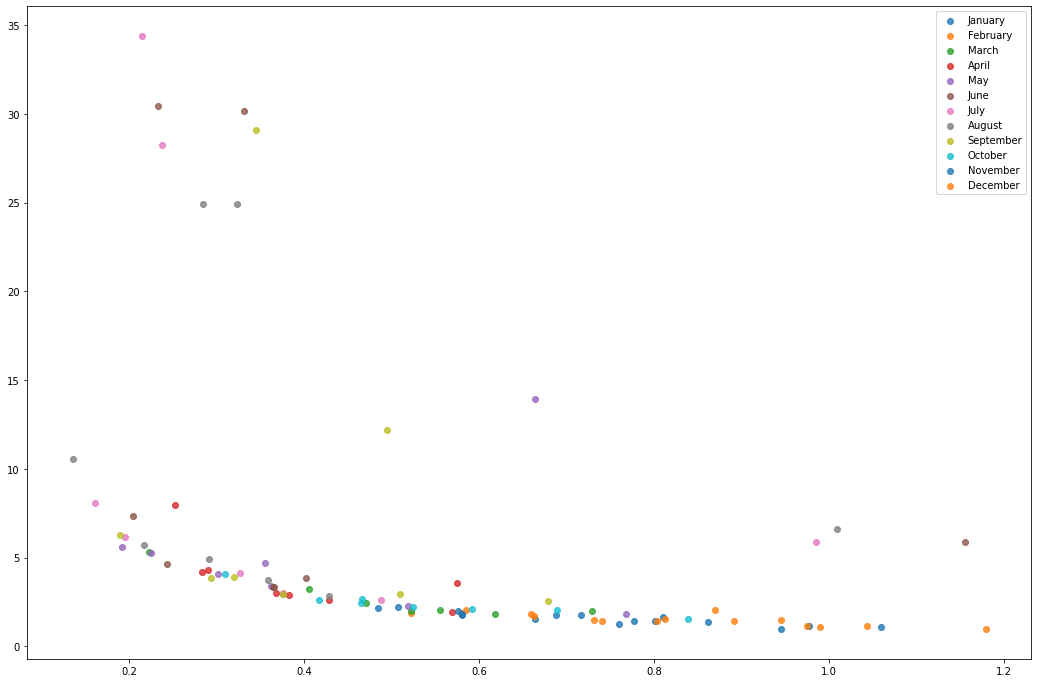

In [20]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(12):
    plt.scatter(fsp_monthly_pm10['sep'].iloc[i::12],
                fsp_monthly_pm10['fim'].iloc[i::12], alpha=0.8)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
      'August', 'September', 'October', 'November', 'December']
plt.legend(months)
plt.show()

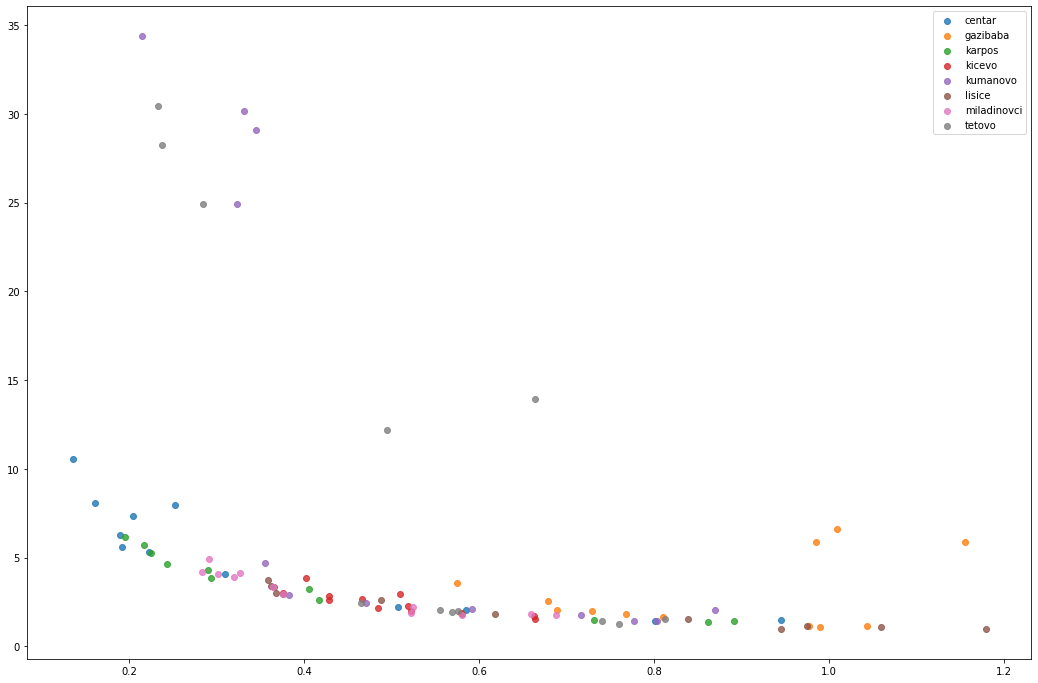

In [21]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(8):
    plt.scatter(fsp_monthly_pm10['sep'].iloc[i*12:i*12+12],
                fsp_monthly_pm10['fim'].iloc[i*12:i*12+12], alpha=0.8)
    plt.legend(locations)
plt.show()

Now we cluster these data points. First we look for the elbow in the Within Cluster Distance metric.

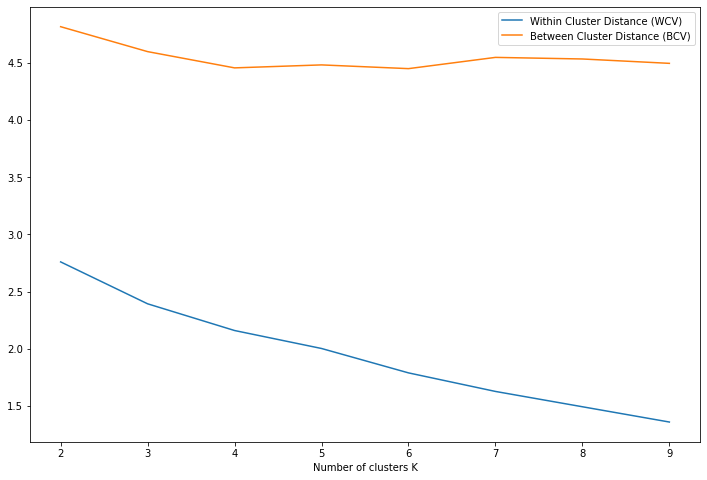

In [22]:
from math import log10
fig1 = plt.figure(figsize=(12, 8))
wcv = {}
bcv = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,max_iter=1000).fit(fsp_monthly_pm10)
    wcv[k] = kmeans.inertia_ 
    centers = kmeans.cluster_centers_
    BCV = 0
    for i in range(len(centers)):
        for j in range(len(centers)):
            BCV += distance.euclidean(centers[i], centers[j])**2
    if(k==1):
        bcv[1] = 0
    else:
        bcv[k] = BCV/(k*(k-1))*100
plt.plot(list(wcv.keys()), [log10(x) for x in wcv.values()],
         label="Within Cluster Distance (WCV)")
plt.plot(list(bcv.keys()), [log10(x) for x in bcv.values()],
         label="Between Cluster Distance (BCV)")
plt.xlabel("Number of clusters K")
plt.legend()
plt.show()

Unfortunately there is no elbow, so we cluster and do silhouette analysis for number of clusters ranging 2-9.

For n_clusters = 2 The average silhouette_score is : 0.8782019209242843
For n_clusters = 3 The average silhouette_score is : 0.7093848632030074
For n_clusters = 4 The average silhouette_score is : 0.5881935608326683
For n_clusters = 5 The average silhouette_score is : 0.5705613590116161
For n_clusters = 6 The average silhouette_score is : 0.636367131620977
For n_clusters = 7 The average silhouette_score is : 0.588374970521648
For n_clusters = 8 The average silhouette_score is : 0.665452151235287
For n_clusters = 9 The average silhouette_score is : 0.6357201572138513


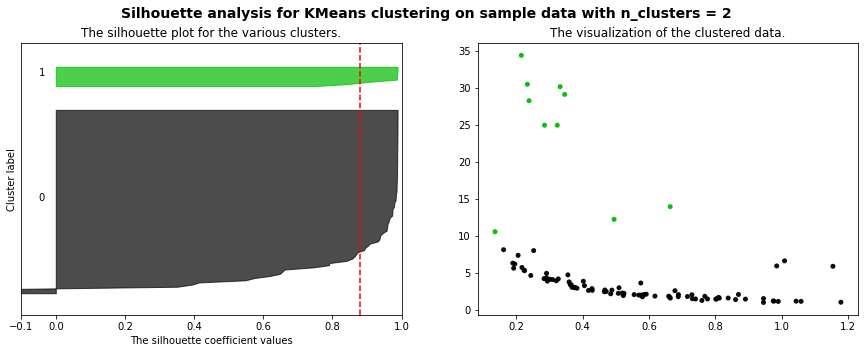

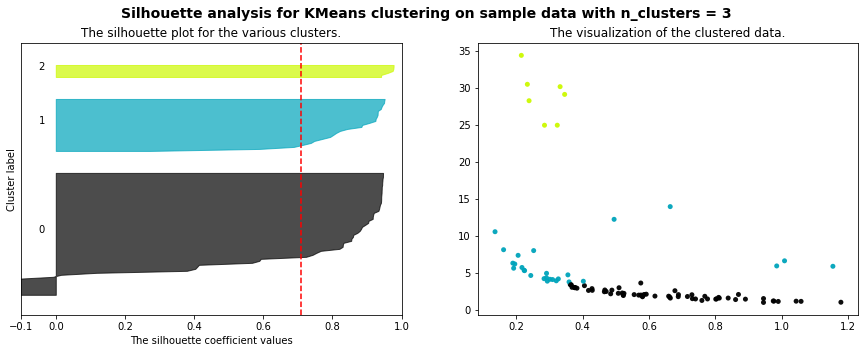

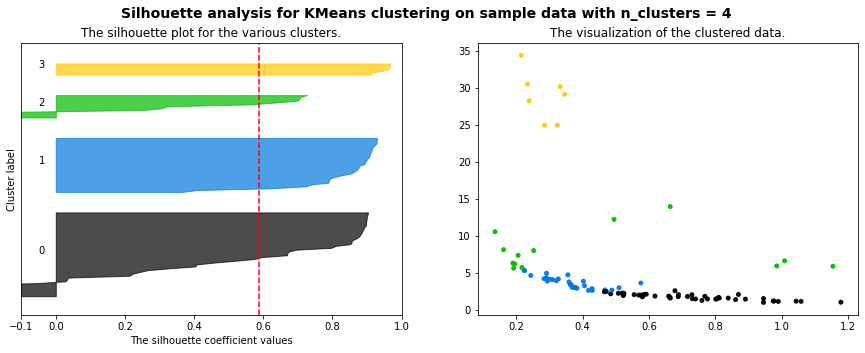

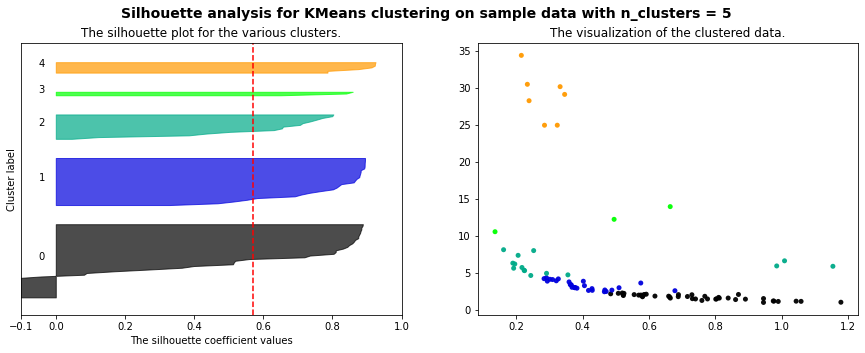

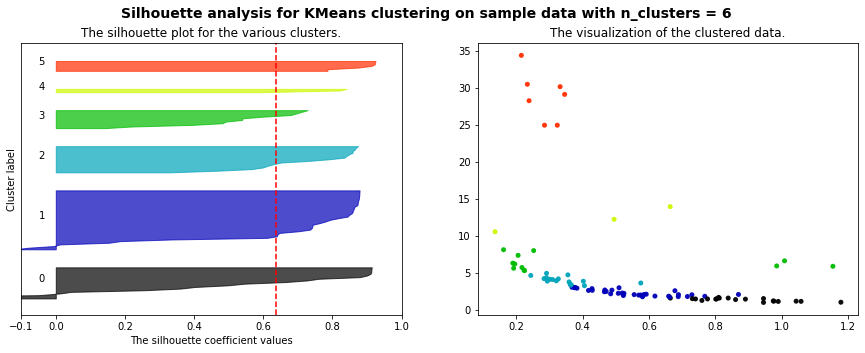

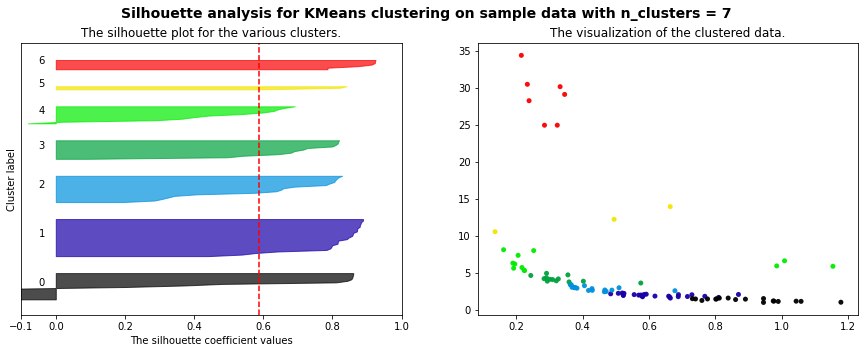

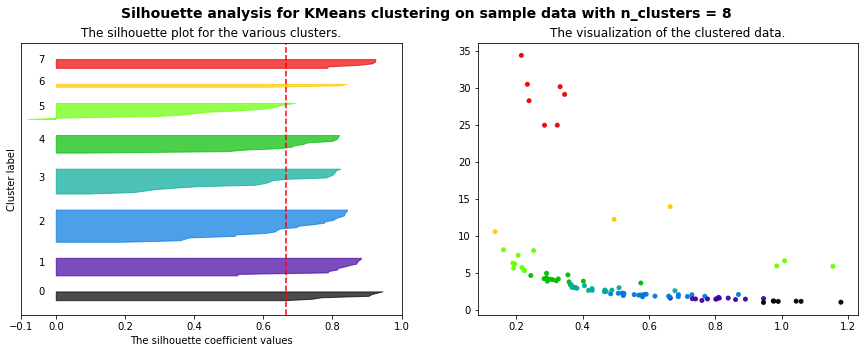

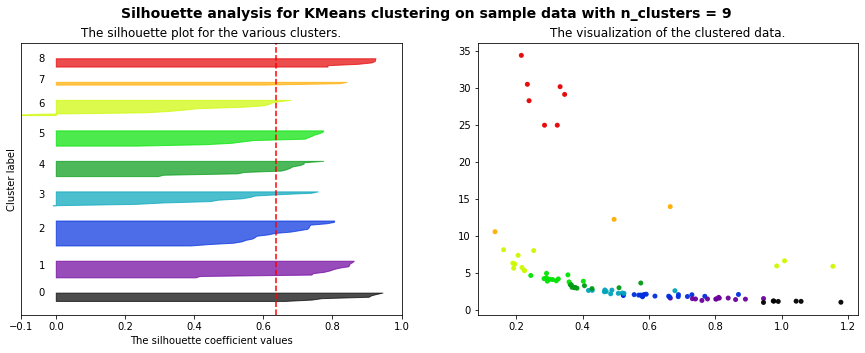

In [37]:
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(fsp_monthly_pm10) + (n_clusters + 1) * 10])

    clusterer = KMeansClusterer(n_clusters, complexity_invariant_distance, repeats=5)
    vectors = [np.array(f) for f in fsp_monthly_pm10.to_numpy()]
    cluster_labels = np.array(clusterer.cluster(vectors, True))


    silhouette_avg = silhouette_score(fsp_monthly_pm10, cluster_labels, metric=complexity_invariant_distance)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(fsp_monthly_pm10, cluster_labels,
                                                  metric=complexity_invariant_distance)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    clrs = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(fsp_monthly_pm10['sep'], fsp_monthly_pm10['fim'], marker='.',
                s=100, lw=0, alpha=0.95, c=clrs, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The results can be interpreted this way: If we look the and k=4 cluster we can clearly see that measurements for summer months in Tetovo and Kumanovo go in one cluster, the measurements for summer months in Centar and Karposh go in another, the third cluster is mostly made up of spring and autumn measurements, while the fourth is mostly made up of winter measurements.

## On seasonal basis

The plan is to do the same as we did with the monthly division of the PM10 series. The steps are completely the same.

In [24]:
fsp_seasonal_pm10 = pd.DataFrame(columns=['loc_ssn','sep','fim'])
sep, fim, loc_ssn = [], [], []
seasons = {'spring':[3, 4, 5], 'summer':[6, 7, 8], 'autumn':[9, 10, 11], 'winter':[12, 1, 2]}
for loc in locations:
    loc_df = data[loc]
    for name, season in seasons.items():
        h = FS.dpik(loc_df.loc[pd.DatetimeIndex(loc_df.time).month.isin(season),
                               'PM10'].reset_index(drop=True))
        SEP, FIM, FSC = FS.SEP_FIM(loc_df.loc[pd.DatetimeIndex(loc_df.time).month.isin(season),
                                              'PM10'].reset_index(drop=True), h, log_trsf=False)
        sep.append(SEP)
        fim.append(FIM)
        loc_ssn.append(loc + "_" + name)
fsp_seasonal_pm10['loc_ssn'] = loc_ssn
fsp_seasonal_pm10['sep'] = sep
fsp_seasonal_pm10['fim'] = fim
fsp_seasonal_pm10.set_index('loc_ssn', inplace=True)
display(fsp_seasonal_pm10)

sep        fim
loc_ssn                                
centar_spring       0.248409   4.951472
centar_summer       0.168198   8.575201
centar_autumn       0.408071   2.807088
centar_winter       0.854224   1.327414
gazibaba_spring     0.732327   4.063163
gazibaba_summer     1.046334  10.166149
gazibaba_autumn     0.829897   1.684133
gazibaba_winter     1.081692   1.076147
karpos_spring       0.343206   3.474501
karpos_summer       0.218213   5.132555
karpos_autumn       0.501766   2.135141
karpos_winter       0.873690   1.316109
kicevo_spring       0.530434   2.139419
kicevo_summer       0.419914   3.770128
kicevo_autumn       0.645343   2.252175
kicevo_winter       0.674039   1.554706
kumanovo_spring     0.466937   2.650531
kumanovo_summer     0.255322  68.122814
kumanovo_autumn     0.653445   5.684122
kumanovo_winter     0.818456   1.868251
lisice_spring       0.483402   2.402736
lisice_summer       0.409322   3.029743
lisice_autumn       0.845768   1.437902
lisice_winter       1.126207   1.068114
miladinovci_spring  0.355342   3.148700
miladinovci_summer  0.330555   4.455462
miladinovci_autumn  0.518340   2.081884
miladinovci_winter  0.674500   1.643291
tetovo_spring       0.673796  14.436674
tetovo_summer       0.205952  68.544593
tetovo_autumn       0.575351  11.130642
tetovo_winter       0.821700   1.202067

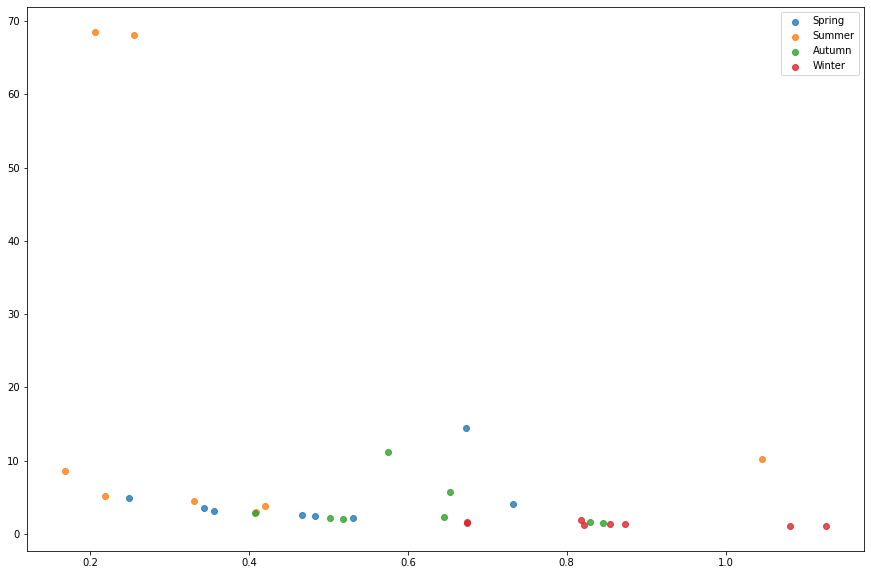

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
for i in range(4):
    plt.scatter(fsp_seasonal_pm10['sep'].iloc[i::4],
                fsp_seasonal_pm10['fim'].iloc[i::4], alpha=0.8)
plt.legend([x.capitalize() for x in seasons.keys()])
plt.show()

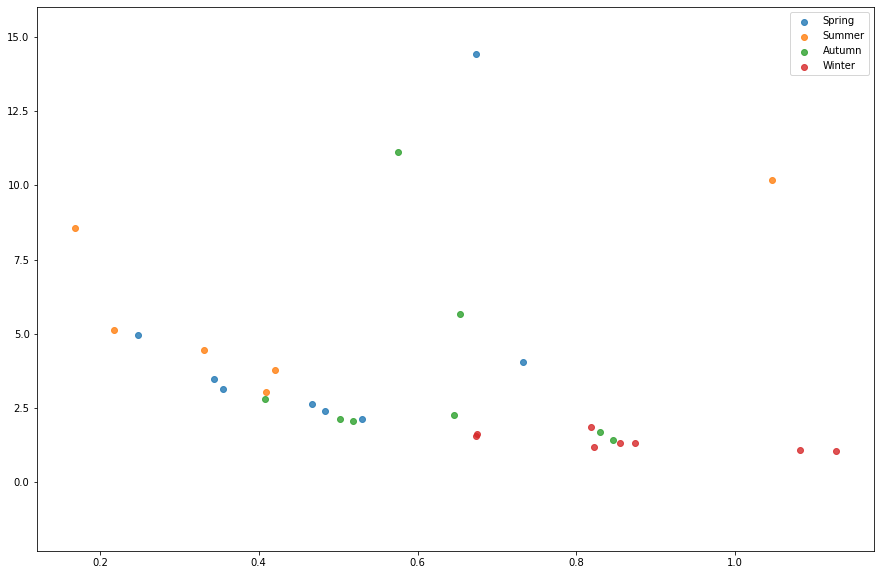

In [26]:
# exclude the two outliers from plot, in order to see other points more clearly
fig, ax = plt.subplots(figsize=(15, 10))
for i in range(4):
    plt.scatter(fsp_seasonal_pm10['sep'].iloc[i::4],
                fsp_seasonal_pm10['fim'].iloc[i::4], alpha=0.8)
plt.legend([x.capitalize() for x in seasons.keys()])
plt.ylim(top=16)
plt.show()

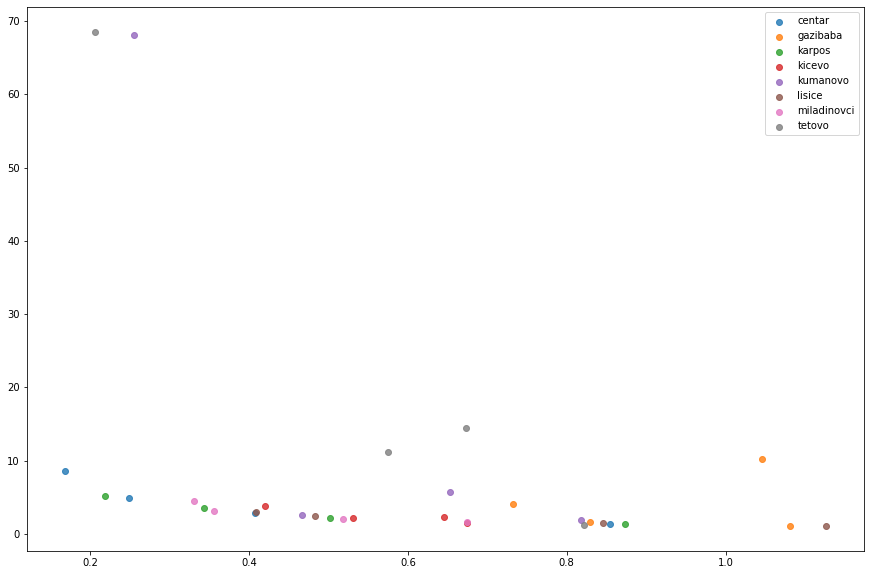

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
for i in range(8):
    plt.scatter(fsp_seasonal_pm10['sep'].iloc[i*4:i*4+4],
                fsp_seasonal_pm10['fim'].iloc[i*4:i*4+4], alpha=0.8)
    plt.legend(locations)
plt.show()

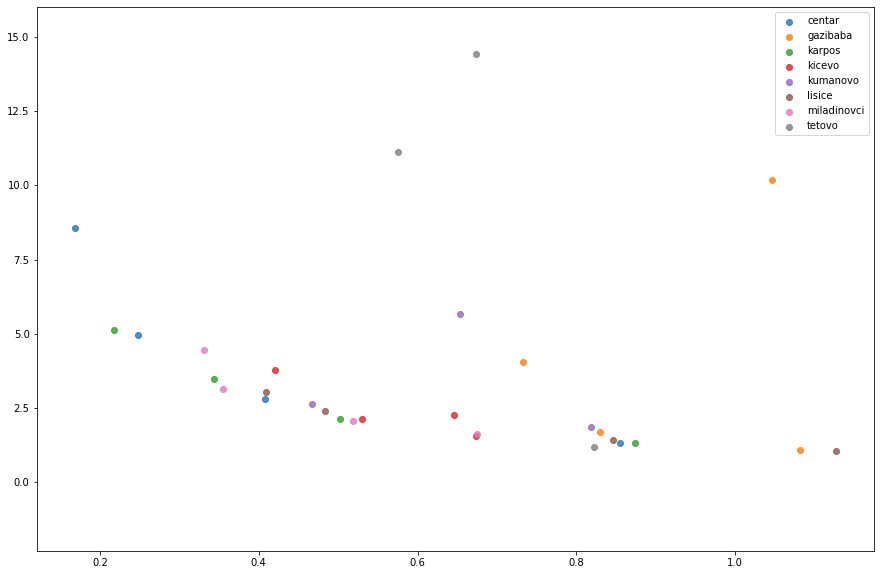

In [28]:
# exclude the two outliers from plot, in order to see other points more clearly
fig, ax = plt.subplots(figsize=(15, 10))
for i in range(8):
    plt.scatter(fsp_seasonal_pm10['sep'].iloc[i*4:i*4+4],
                fsp_seasonal_pm10['fim'].iloc[i*4:i*4+4], alpha=0.8)
    plt.legend(locations)
plt.ylim(top=16)
plt.show()

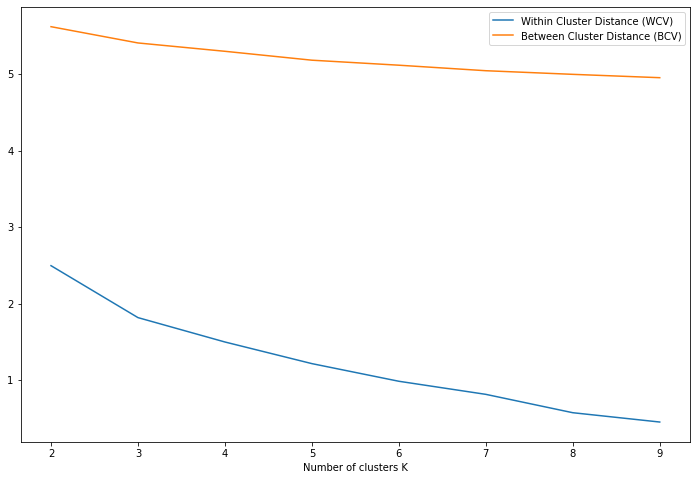

In [29]:
from math import log10
fig1 = plt.figure(figsize=(12, 8))
wcv = {}
bcv = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,max_iter=1000).fit(fsp_seasonal_pm10)
    wcv[k] = kmeans.inertia_ 
    centers = kmeans.cluster_centers_
    BCV = 0
    for i in range(len(centers)):
        for j in range(len(centers)):
            BCV += distance.euclidean(centers[i], centers[j])**2
    if(k==1):
        bcv[1] = 0
    else:
        bcv[k] = BCV/(k*(k-1))*100
plt.plot(list(wcv.keys()), [log10(x) for x in wcv.values()],
         label="Within Cluster Distance (WCV)")
plt.plot(list(bcv.keys()), [log10(x) for x in bcv.values()],
         label="Between Cluster Distance (BCV)")
plt.xlabel("Number of clusters K")
plt.legend()
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.7945617768127327
For n_clusters = 3 The average silhouette_score is : 0.46206280131780364
For n_clusters = 4 The average silhouette_score is : 0.491511775349423
For n_clusters = 5 The average silhouette_score is : 0.48492399236032346
For n_clusters = 6 The average silhouette_score is : 0.7330865661813311
For n_clusters = 7 The average silhouette_score is : 0.6199309931497551
For n_clusters = 8 The average silhouette_score is : 0.5221694425381951
For n_clusters = 9 The average silhouette_score is : 0.6735704721200211


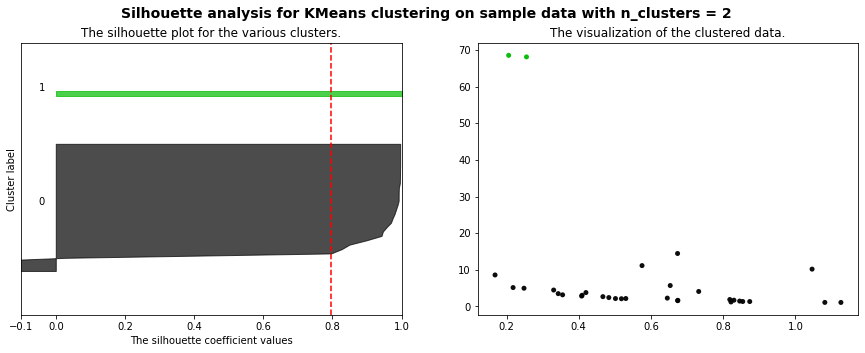

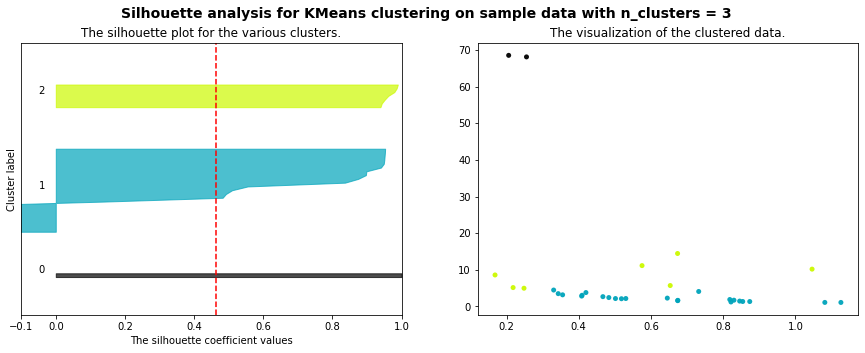

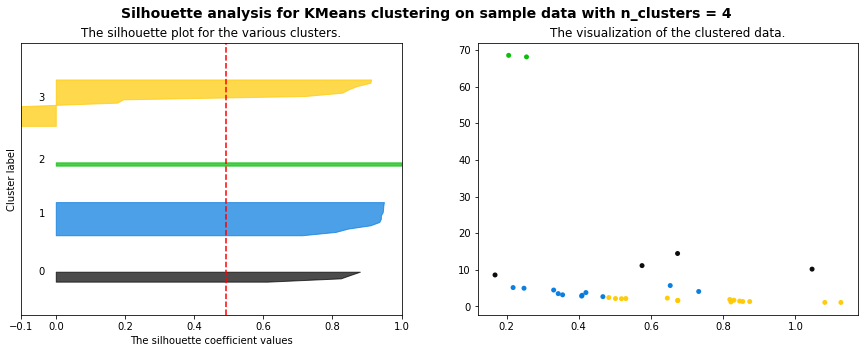

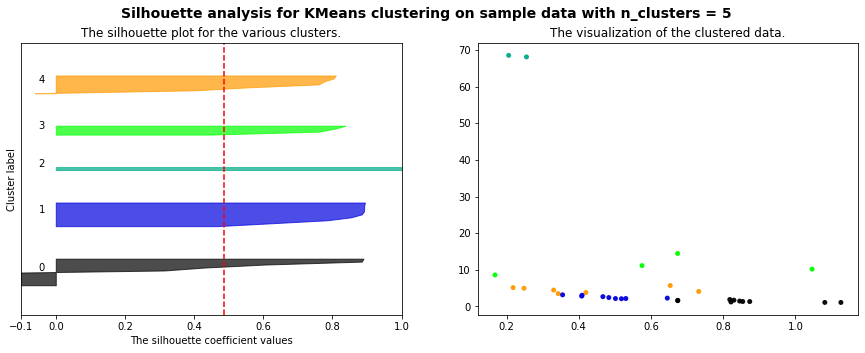

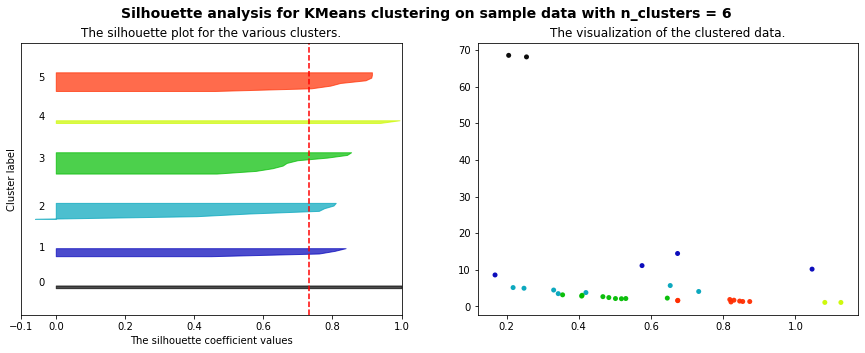

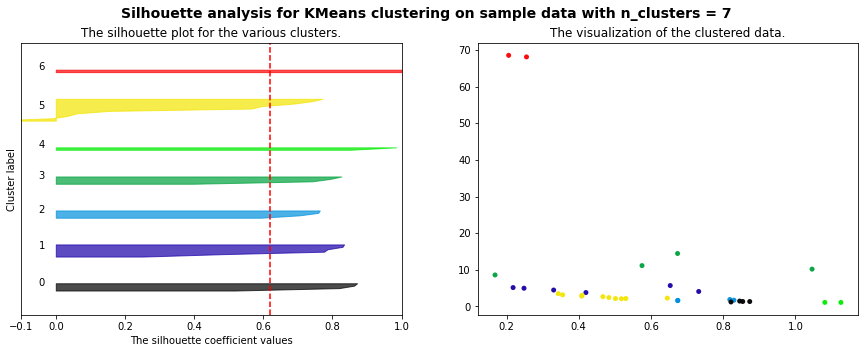

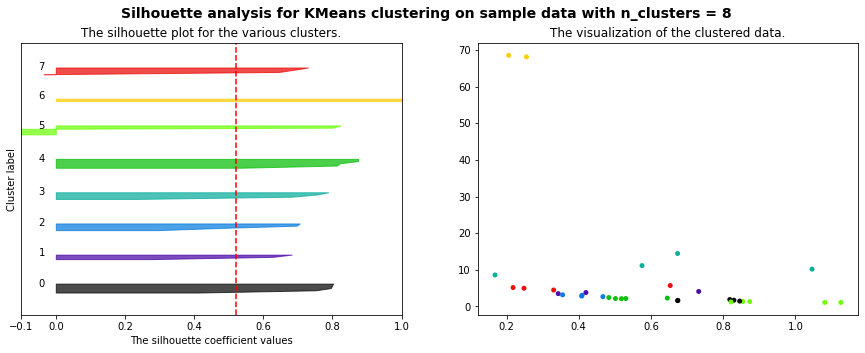

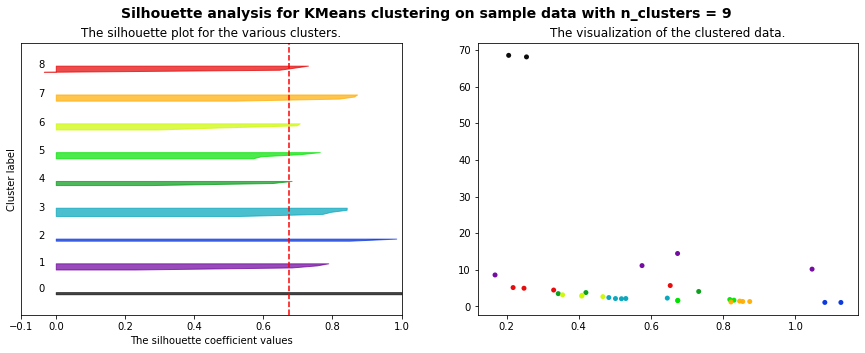

In [30]:
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(fsp_seasonal_pm10) + (n_clusters + 1) * 10])

    clusterer = KMeansClusterer(n_clusters, complexity_invariant_distance)
    vectors = [np.array(f) for f in fsp_seasonal_pm10.to_numpy()]
    cluster_labels = np.array(clusterer.cluster(vectors, True))


    silhouette_avg = silhouette_score(fsp_seasonal_pm10, cluster_labels, metric=complexity_invariant_distance)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(fsp_seasonal_pm10, cluster_labels,
                                                  metric=complexity_invariant_distance)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    clrs = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(fsp_seasonal_pm10['sep'], fsp_seasonal_pm10['fim'], marker='.',
                s=100, lw=0, alpha=0.95, c=clrs, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Hierarchical clustering with Complexity-Invariant distance

In this section we showcase the Agglomerative Hierarchical Clustering method, using the Complexity-Invariant distance metric. In order to use it, we must first combine all PM10 measurements from our 8 locations into one, since we have to work with columns of same length.

In [33]:
data_pm10 = dict()
for loc in locations:
    temp_df = data[loc][['time','PM10']]
    data_pm10[loc] = temp_df
df_merged_locations = data_pm10['centar']
for loc in locations:
    if loc == 'centar':
        continue
    df_merged_locations = pd.DataFrame.merge(df_merged_locations,data_pm10[loc],
                                             on='time', suffixes=('', '_'+loc))
df_merged_locations = df_merged_locations.rename(columns={'PM10':'PM10_centar'})
display(df_merged_locations)

time  PM10_centar  PM10_gazibaba  PM10_karpos  \
0    2016-06-13 12:00:00     2.691921       3.832763     2.523326   
1    2016-06-13 15:00:00     2.550226       0.741937     2.191654   
2    2016-06-13 18:00:00     2.605648       0.746688     2.150599   
3    2016-06-13 21:00:00     2.910719       3.823410     2.144761   
4    2016-06-14 00:00:00     3.216072       4.661645     2.851862   
...                  ...          ...            ...          ...   
6179 2020-03-08 13:00:00     1.609438       1.609438     1.791759   
6180 2020-03-08 14:00:00     1.945910       1.791759     2.197225   
6181 2020-03-08 15:00:00     2.197225       1.945910     2.397895   
6182 2020-03-08 16:00:00     2.564949       2.197225     2.564949   
6183 2020-03-08 17:00:00     2.890372       2.833213     2.944439   

      PM10_kicevo  PM10_kumanovo  PM10_lisice  PM10_miladinovci  PM10_tetovo  
0        2.515274       1.763017     2.609334          2.751748     3.916812  
1        1.729884       1.860975     1.137833          2.432736     1.808289  
2        3.102342       3.377929     1.085189          2.242835     2.451867  
3        3.303952       1.968510     1.969906          2.302585     3.352357  
4        3.177220       3.427515     3.729301          3.257712     4.278331  
...           ...            ...          ...               ...          ...  
6179     3.044522       2.890372     1.945910          2.708050     2.302585  
6180     3.218876       3.091042     1.945910          3.332205     2.890372  
6181     3.496508       3.178054     2.397895          3.332205     3.135494  
6182     3.555348       3.496508     2.197225          3.332205     2.890372  
6183     3.806662       3.433987     3.258097          3.218876     3.401197  

[6184 rows x 9 columns]

In [34]:
distances = np.zeros((8, 8))
for i in range(8):
    for j in range(8):
        a = df_merged_locations['PM10_' + locations[i]]
        b = df_merged_locations['PM10_' + locations[j]]
        distances[i][j] = complexity_invariant_distance(a, b)

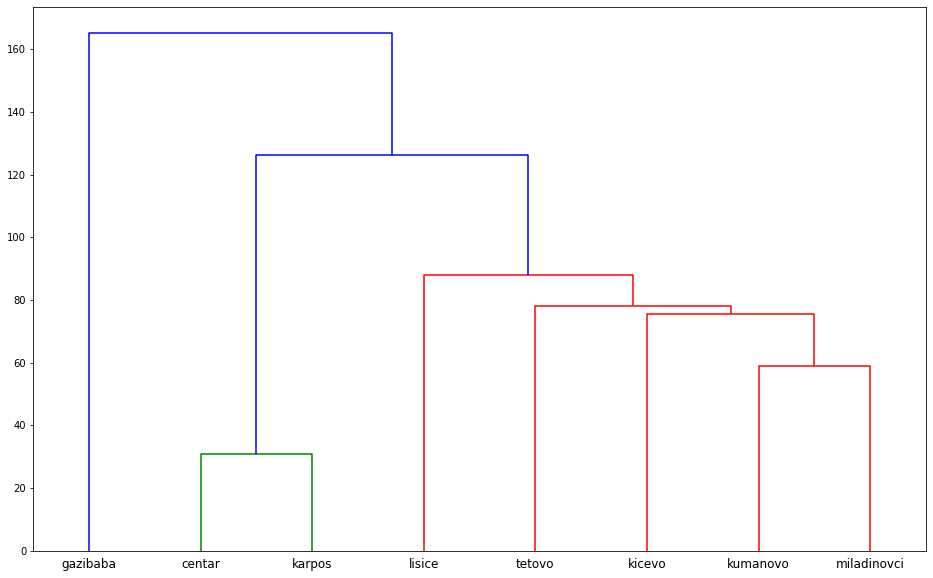

In [35]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

fig = plt.figure(figsize=(16, 10))
linkage_matrix = linkage(squareform(distances), 'ward')
dendrogram(linkage_matrix, labels=locations, p=4)

plt.show()

From the dendogram we can visualize how the clusters would form. As we can see, centar and karposh are the most similar locations, which makes sense since they are geographically next to each other. The odd thing is that the gazibaba PM10 measurements are the ones that are the least similar to all other measurement stations.